# A6 Convolutional Networks


Rename the `ConvNet2D` class in the following code cell to class `ConvNet` and modify it so that it can classify two-dimensional data, like images, <font color=red>and one-dimensional data</font>.  Believe it or not, this will only require some changes in the constructor.  Use the tuple passed in as `input_shape` to determine whether the created `ConvNet` object should handle one or two-dimensional data.

Do not leave the definition of class `ConvNet2D` in your notebook!

# `ConvNet2D` to be changed to `ConvNet`

In [5]:
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt

In [6]:
# Replace next line with    class ConvNet(torch.nn.Module)
#   and continue making other changes as specified above.
class ConvNet(torch.nn.Module):  
    
    def __init__(self, input_shape, conv_specs, fc_specs, n_outputs, activation_function='tanh', device='cpu'):
        '''Example for MNIST:
        ConvNet2D((1, 28, 28), [(20, 3, 1), (10, 4, 2)], [20], 'tanh', 'cuda')
        '''

        super().__init__()
        
        self.input_shape = input_shape
        self.device = device
        print('ConvNet2D: Using device', self.device)
        self.activation_function = torch.nn.Tanh() if activation_function == 'tanh' else torch.nn.ReLU()

        if len(input_shape) == 1:
            is_1d = 1
        else:
            is_1d = 0

        # Create all convolutional layers
        n_in = input_shape[0]
        self.conv_layers = torch.nn.Sequential()

        for nh, patch_size, stride in conv_specs:
            if is_1d:
                
                self.conv_layers.append(torch.nn.Sequential(
                    torch.nn.Conv1d(n_in, nh, patch_size, stride),
                    self.activation_function))
            else:
                
                self.conv_layers.append(torch.nn.Sequential(
                    torch.nn.Conv2d(n_in, nh, patch_size, stride),
                    self.activation_function))
            n_in = nh

        # To determine the number of inputs to the first fully connected layer,
        # pass some zero input samples through the conv_layers and see how many values result
        if is_1d:
            z = self.conv_layers(torch.zeros([1, 1] + list(input_shape)))
        else:
            z = self.conv_layers(torch.zeros([1] + list(input_shape)))

        
        z = z.reshape(1, -1)
        n_in = z.shape[1]


        # Create all fully connected layers.
        self.fc_layers = torch.nn.Sequential()
        for nh in fc_specs:
            self.fc_layers.append( torch.nn.Sequential( torch.nn.Linear(n_in, nh),
                                                        self.activation_function) )
            n_in = nh

        output_layer = torch.nn.Linear(n_in, n_outputs)
        self.fc_layers.append(output_layer)
        
        self.pc_trace = []
        self.best_pc_val = None
        self.to(self.device)

    def _forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Zs = [X]
        for conv_layer in self.conv_layers:
            Zs.append( conv_layer(Zs[-1]) )

        # Flatten outputs from last convolutional layer.
        Zs[-1] = Zs[-1].reshape(n_samples, -1)
        for fc_layer in self.fc_layers:
            Zs.append( fc_layer(Zs[-1]) )

        return Zs
    
    def forward(self, X, keep_all_outputs=False):
        if not isinstance(X, torch.Tensor):
            X = self._X_as_torch(X)
        Zs = self._forward_all_outputs(X)
        
        if keep_all_outputs:
            self.Zs = Zs
            
        return Zs[-1]
    

    def _X_as_torch(self, X):
        if isinstance(X, torch.Tensor):
            return X
        else:
            if len(self.input_shape) == 1:
                return torch.from_numpy(X.reshape([-1, 1] + list(self.input_shape)).astype(np.float32)).to(self.device)
            else:
                return torch.from_numpy(X.reshape([-1] + list(self.input_shape)).astype(np.float32)).to(self.device)



    def _T_as_torch(self, T):
        if isinstance(T, torch.Tensor):
            return T
        else:
            return torch.from_numpy(T.astype(np.int64)).to(self.device)

    def percent_correct(self, Yclasses, T):
        if isinstance(T, torch.Tensor):
            return (Yclasses == T).float().mean().item() * 100
        else:
            return (Yclasses == T).mean().item() * 100
    


    def train(self, Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size=-1, method='sgd', learning_rate=0.01, verbose=True):
        
        # Assuming Ttrain includes all possible class labels
        self.classes = np.unique(Ttrain)

        self.X_means = Xtrain.mean(0)
        self.X_stds = Xtrain.std(0)
        self.X_stds[self.X_stds == 0] = np.mean(self.X_stds)

        Xtrain = (Xtrain - self.X_means) / self.X_stds
        Xval = (Xval - self.X_means) / self.X_stds

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        loss_f = torch.nn.CrossEntropyLoss()
        
        if batch_size == -1:
            batch_size = Xtrain.shape[0]

        self.batch_size = batch_size  # remember this for use in forward functions

        for epoch in range(n_epochs):

            for first in range(0, Xtrain.shape[0], batch_size):
                Xtrain_batch = Xtrain[first:first + batch_size]
                Ttrain_batch = Ttrain[first:first + batch_size]

                # Set data matrices to torch.tensors if not already.
                Xtrain_batch = self._X_as_torch(Xtrain_batch)
                Ttrain_batch = self._T_as_torch(Ttrain_batch)

                Y = self(Xtrain_batch)
                loss = loss_f(Y, Ttrain_batch)
                loss.backward()

                optimizer.step()
                optimizer.zero_grad()

            with torch.no_grad():
                pc_train = self.percent_correct(self.use(Xtrain, standardized=True), Ttrain)
                pc_val = self.percent_correct(self.use(Xval, standardized=True), Tval)
                self.pc_trace.append([pc_train, pc_val])

                if self.best_pc_val is None or pc_val > self.best_pc_val:
                    self.best_pc_val = pc_val
                    self.best_epoch = epoch + 1
                    # Save weights to be restored when done training
                    self.best_parameters = [p.clone() for p in self.parameters()]

            if verbose and (epoch + 1) % max(1, (n_epochs // 10)) == 0:
                print(f'{method} Epoch {epoch + 1} % Correct: Train {self.pc_trace[-1][0]:.1f}'
                      f' Val {self.pc_trace[-1][1]:.1f}')

        # Restore weights that resulted in best_pc_val
        for p, bestp in zip(self.parameters(), self.best_parameters):
            p.data = bestp.clone()

        return self

    def _softmax(self, Y):
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1,1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X, standardized=False, return_probs=False, keep_all_outputs=False):
        
        if not standardized:
            X = (X - self.X_means) / self.X_stds

        classes = []
        probs = []
        return_numpy = False
        
        for first in range(0, X.shape[0], self.batch_size):
            X_batch = X[first:first + self.batch_size]

            if not isinstance(X_batch, torch.Tensor):
                X_batch = self._X_as_torch(X_batch)
                return_numpy = True

            with torch.no_grad():
                
                Y = self(X_batch, keep_all_outputs=keep_all_outputs)
                class_index = torch.argmax(Y, axis=1).cpu().numpy()
                classes.extend(self.classes[class_index])
                
                if return_probs:
                    probs.extend(self._softmax(Y).cpu().numpy())
                
        if return_numpy:
            classes = np.array(classes)
            probs = np.array(probs)
                    
        if return_probs:
            return classes, probs
        else:
            return classes

The following code cell tests your code with the MNIST data set. 

In [7]:
import gzip
import pickle

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
# device = 'cpu'

with gzip.open('mnist.pkl.gz', 'rb') as f:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1]
Xval = valid_set[0]
Tval = valid_set[1]
Xtest = test_set[0]
Ttest = test_set[1]

ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 88.6 Val 90.0
adam Epoch 2 % Correct: Train 92.6 Val 93.5
adam Epoch 3 % Correct: Train 94.9 Val 95.5
adam Epoch 4 % Correct: Train 96.2 Val 96.5
adam Epoch 5 % Correct: Train 97.0 Val 97.1
adam Epoch 6 % Correct: Train 97.6 Val 97.4
adam Epoch 7 % Correct: Train 98.0 Val 97.6
adam Epoch 8 % Correct: Train 98.3 Val 97.7
adam Epoch 9 % Correct: Train 98.5 Val 97.9
adam Epoch 10 % Correct: Train 98.7 Val 98.0
% Correct: Train 98.7 Val 98.0 Test 98.1


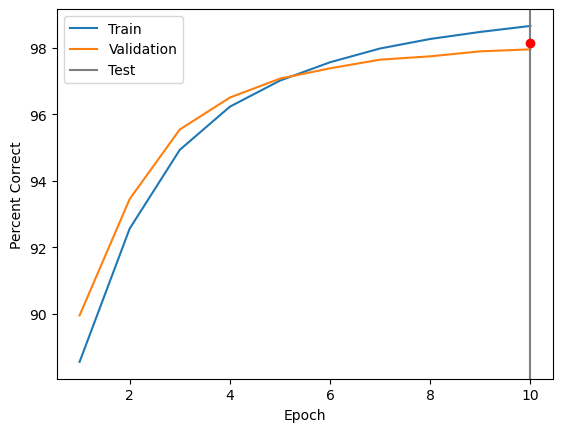

In [ ]:
n_train = 50000
Xtrain = Xtrain[:n_train]
Ttrain = Ttrain[:n_train]
# Notice the use of :,d to format integers with comma separators.
if n_train < 50000:
    print(f'Only only {n_train:,d} training samples to reduce computation time.')

conv_specs = [(40, 4, 1), (20, 3, 2), (20, 3, 2)]
fc_specs = [20]
input_shape = (1, 28, 28)
n_outputs = 10
n_epochs = 10
batch_size = 500
method = 'adam'
learning_rate = 0.001
device = 'cpu'   # or 'cuda'

nnet = ConvNet(input_shape, conv_specs, fc_specs, n_outputs, activation_function='tanh', device=device)
nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size, method, learning_rate)

pc_train = nnet.percent_correct(nnet.use(Xtrain), Ttrain)
pc_val = nnet.percent_correct(nnet.use(Xval), Tval)
pc_test = nnet.percent_correct(nnet.use(Xtest), Ttest)

print(f'% Correct: Train {pc_train:.1f} Val {pc_val:.1f} Test {pc_test:.1f}')

plt.plot(1 + np.arange(len(nnet.pc_trace)), nnet.pc_trace)
plt.axvline(nnet.best_epoch, color='gray')
plt.plot(nnet.best_epoch, pc_test, 'ro')
plt.legend(('Train', 'Validation', 'Test'))
plt.xlabel('Epoch')
plt.ylabel('Percent Correct');

In [9]:
def confusion_matrix(Y_classes, T, class_names, background_cmap=None):
    class_T = np.arange(len(class_names))
    table = []
    for true_class in class_T:  #class_names:
        row = []
        for Y_class in class_T:  # class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    print('Percent Correct (Actual class in rows, Predicted class in columns)')
    if background_cmap:
        return conf_matrix.style.background_gradient(cmap=background_cmap, axis=1).format('{:.1f}')
    else:
        return conf_matrix

In [10]:
confusion_matrix(nnet.use(Xtest), Ttest, range(10), 'Blues')

Percent Correct (Actual class in rows, Predicted class in columns)


# Requirement 1

Using the full training set of MNIST digits, run a few experiments to answer the following questions. Write a few sentences about what you observe from your experiments you run to answer these questions.

1. Does your `ConvNet` perform worse or better without any fully-connected layers?
2. Does your `ConvNet` perform worse or better without any convolutional layers?
3. How does it perform with no convolutional layers and no fully-connected layers?
4. Try several different values for `batch_size`, `n_epochs`, and `learning_rate`.  Which values result in better results on the test data?

Remember, you can set `conv_specs` and/or `fc_specs` to `[]`.

# Answer:

Ok, so I will use the network of cell 4 as a baseline for comparison. Then, I will only remove the fully-connected layers to see how it performs. After that I will only remove the convolutional layers to see what the performance is. And finally, I will remove both to see how it behaves. I will also test differnet hyperparameters for each of the neural nets (baseline, no fully-connected, no concolutional and no either)

I will use 3 different values for each of the hyperparameters. 
The hyperparameters are:  

<font color=red>Batch size:</font>   256, 512 and 1024


<font color=red>Number of epochs:</font>   10, 20 and 30


<font color=red>Learning Rates:</font>   0.01, 0.001 and 0.0001 

These different parameters will give us a good understanding of how these parameters affect the performance. 


This will give us a total of <font color=red>27 different hyperparameter combinations</font>  .
Since we have <font color=red>4 architectures</font> , it will give us <font color=red>108 different neural networks!</font> 

The following is the code for the experiments:



Testing baseline with batch size 256, number of epochs 10, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 93.9 Val 94.4
adam Epoch 2 % Correct: Train 94.8 Val 95.2
adam Epoch 3 % Correct: Train 95.3 Val 95.4
adam Epoch 4 % Correct: Train 95.7 Val 95.6
adam Epoch 5 % Correct: Train 96.2 Val 96.2
adam Epoch 6 % Correct: Train 95.5 Val 95.6
adam Epoch 7 % Correct: Train 95.9 Val 95.8
adam Epoch 8 % Correct: Train 95.8 Val 95.7
adam Epoch 9 % Correct: Train 96.3 Val 96.0
adam Epoch 10 % Correct: Train 95.9 Val 95.9
baseline - batch size: 256, epochs: 10, lr: 0.01: % correct: train 96.2 val 96.2 test 96.0


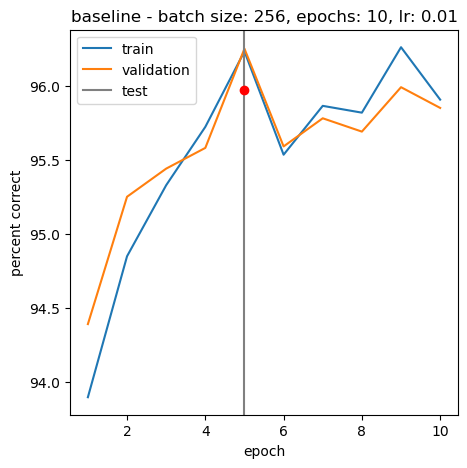

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 256, number of epochs 10, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 91.5 Val 93.1
adam Epoch 2 % Correct: Train 95.1 Val 95.8
adam Epoch 3 % Correct: Train 96.7 Val 97.0
adam Epoch 4 % Correct: Train 97.5 Val 97.5
adam Epoch 5 % Correct: Train 98.0 Val 97.7
adam Epoch 6 % Correct: Train 98.3 Val 97.9
adam Epoch 7 % Correct: Train 98.5 Val 98.0
adam Epoch 8 % Correct: Train 98.7 Val 98.0
adam Epoch 9 % Correct: Train 98.8 Val 98.2
adam Epoch 10 % Correct: Train 99.1 Val 98.2
baseline - batch size: 256, epochs: 10, lr: 0.001: % correct: train 99.1 val 98.2 test 98.0


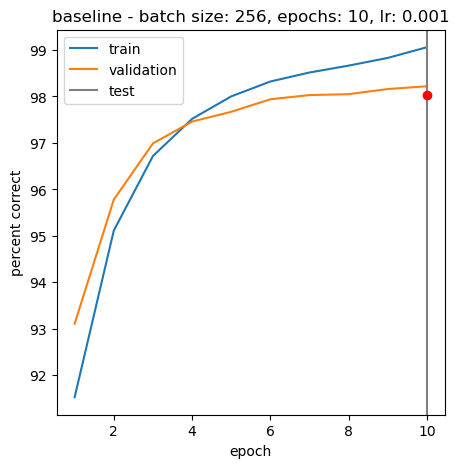

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 256, number of epochs 10, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 75.6 Val 77.9
adam Epoch 2 % Correct: Train 83.0 Val 84.9
adam Epoch 3 % Correct: Train 86.0 Val 87.6
adam Epoch 4 % Correct: Train 87.7 Val 89.2
adam Epoch 5 % Correct: Train 89.0 Val 90.3
adam Epoch 6 % Correct: Train 89.9 Val 91.2
adam Epoch 7 % Correct: Train 90.6 Val 92.1
adam Epoch 8 % Correct: Train 91.4 Val 92.8
adam Epoch 9 % Correct: Train 92.1 Val 93.4
adam Epoch 10 % Correct: Train 92.7 Val 93.9
baseline - batch size: 256, epochs: 10, lr: 0.0001: % correct: train 92.7 val 93.9 test 93.2


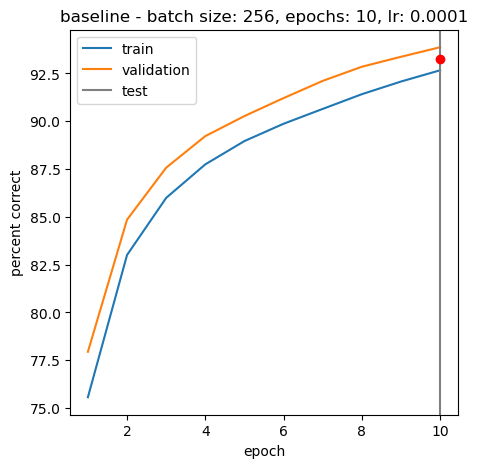

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 256, number of epochs 20, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 95.6 Val 95.6
adam Epoch 4 % Correct: Train 95.7 Val 95.8
adam Epoch 6 % Correct: Train 96.3 Val 96.5
adam Epoch 8 % Correct: Train 96.4 Val 96.5
adam Epoch 10 % Correct: Train 95.9 Val 95.9
adam Epoch 12 % Correct: Train 96.0 Val 95.9
adam Epoch 14 % Correct: Train 95.6 Val 95.6
adam Epoch 16 % Correct: Train 96.0 Val 96.1
adam Epoch 18 % Correct: Train 95.9 Val 95.9
adam Epoch 20 % Correct: Train 95.8 Val 95.7
baseline - batch size: 256, epochs: 20, lr: 0.01: % correct: train 96.3 val 96.5 test 96.0


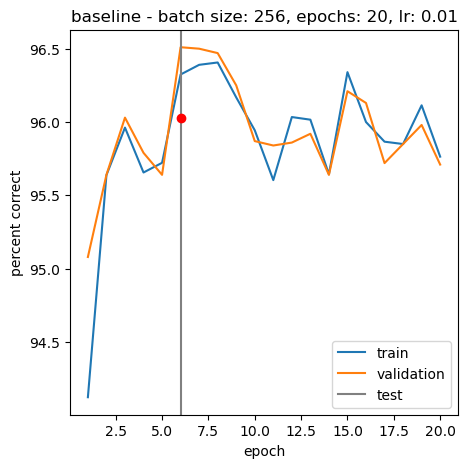

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 256, number of epochs 20, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 94.9 Val 95.5
adam Epoch 4 % Correct: Train 97.3 Val 97.2
adam Epoch 6 % Correct: Train 98.1 Val 97.5
adam Epoch 8 % Correct: Train 98.7 Val 97.9
adam Epoch 10 % Correct: Train 98.9 Val 98.0
adam Epoch 12 % Correct: Train 99.1 Val 98.0
adam Epoch 14 % Correct: Train 99.2 Val 98.0
adam Epoch 16 % Correct: Train 99.4 Val 98.1
adam Epoch 18 % Correct: Train 99.5 Val 98.1
adam Epoch 20 % Correct: Train 99.6 Val 98.2
baseline - batch size: 256, epochs: 20, lr: 0.001: % correct: train 99.6 val 98.2 test 98.2


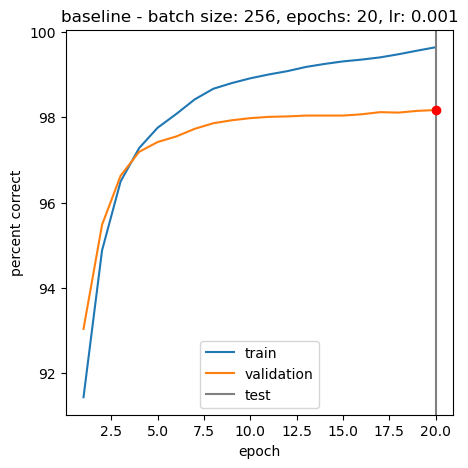

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 256, number of epochs 20, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 84.5 Val 86.6
adam Epoch 4 % Correct: Train 88.4 Val 90.0
adam Epoch 6 % Correct: Train 90.3 Val 91.8
adam Epoch 8 % Correct: Train 91.9 Val 93.1
adam Epoch 10 % Correct: Train 93.0 Val 94.1
adam Epoch 12 % Correct: Train 94.0 Val 94.8
adam Epoch 14 % Correct: Train 94.7 Val 95.5
adam Epoch 16 % Correct: Train 95.3 Val 96.1
adam Epoch 18 % Correct: Train 95.8 Val 96.4
adam Epoch 20 % Correct: Train 96.3 Val 96.7
baseline - batch size: 256, epochs: 20, lr: 0.0001: % correct: train 96.3 val 96.7 test 96.3


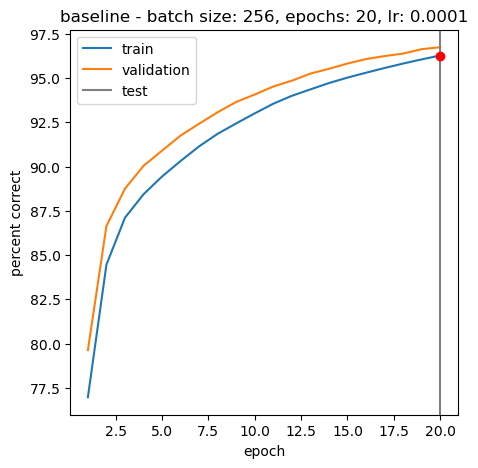

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 256, number of epochs 30, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 95.8 Val 96.2
adam Epoch 6 % Correct: Train 96.0 Val 96.1
adam Epoch 9 % Correct: Train 96.4 Val 96.0
adam Epoch 12 % Correct: Train 96.2 Val 96.3
adam Epoch 15 % Correct: Train 95.9 Val 96.5
adam Epoch 18 % Correct: Train 96.5 Val 96.4
adam Epoch 21 % Correct: Train 96.2 Val 96.2
adam Epoch 24 % Correct: Train 95.9 Val 95.9
adam Epoch 27 % Correct: Train 96.3 Val 96.2
adam Epoch 30 % Correct: Train 96.1 Val 96.1
baseline - batch size: 256, epochs: 30, lr: 0.01: % correct: train 96.4 val 96.6 test 96.5


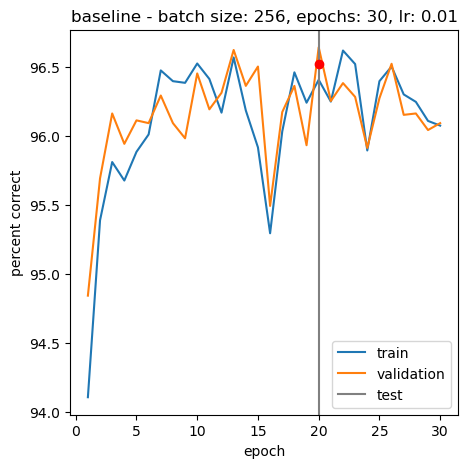

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 256, number of epochs 30, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 96.8 Val 97.0
adam Epoch 6 % Correct: Train 98.3 Val 97.8
adam Epoch 9 % Correct: Train 98.9 Val 98.1
adam Epoch 12 % Correct: Train 99.2 Val 98.3
adam Epoch 15 % Correct: Train 99.4 Val 98.3
adam Epoch 18 % Correct: Train 99.7 Val 98.4
adam Epoch 21 % Correct: Train 99.7 Val 98.4
adam Epoch 24 % Correct: Train 99.7 Val 98.4
adam Epoch 27 % Correct: Train 99.8 Val 98.3
adam Epoch 30 % Correct: Train 99.9 Val 98.4
baseline - batch size: 256, epochs: 30, lr: 0.001: % correct: train 99.6 val 98.5 test 98.4


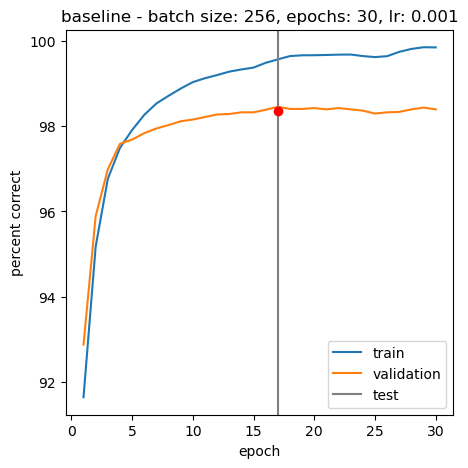

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 256, number of epochs 30, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 86.7 Val 88.0
adam Epoch 6 % Correct: Train 90.1 Val 91.2
adam Epoch 9 % Correct: Train 92.2 Val 93.0
adam Epoch 12 % Correct: Train 93.7 Val 94.5
adam Epoch 15 % Correct: Train 94.8 Val 95.4
adam Epoch 18 % Correct: Train 95.6 Val 96.0
adam Epoch 21 % Correct: Train 96.4 Val 96.7
adam Epoch 24 % Correct: Train 96.9 Val 97.0
adam Epoch 27 % Correct: Train 97.2 Val 97.2
adam Epoch 30 % Correct: Train 97.5 Val 97.4
baseline - batch size: 256, epochs: 30, lr: 0.0001: % correct: train 97.5 val 97.4 test 97.2


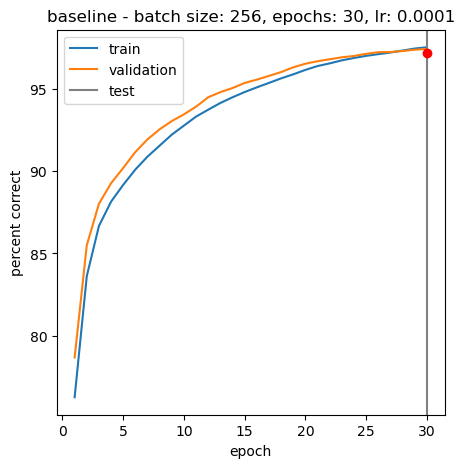

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 512, number of epochs 10, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 95.2 Val 95.7
adam Epoch 2 % Correct: Train 96.0 Val 96.2
adam Epoch 3 % Correct: Train 96.4 Val 96.2
adam Epoch 4 % Correct: Train 97.1 Val 96.9
adam Epoch 5 % Correct: Train 96.9 Val 96.6
adam Epoch 6 % Correct: Train 97.3 Val 96.8
adam Epoch 7 % Correct: Train 97.0 Val 96.8
adam Epoch 8 % Correct: Train 97.1 Val 96.8
adam Epoch 9 % Correct: Train 97.3 Val 97.0
adam Epoch 10 % Correct: Train 97.3 Val 96.9
baseline - batch size: 512, epochs: 10, lr: 0.01: % correct: train 97.3 val 97.0 test 97.0


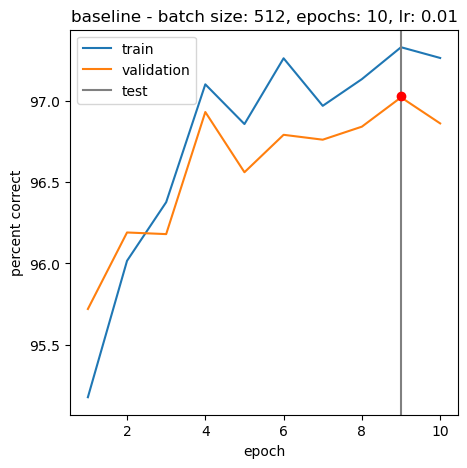

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 512, number of epochs 10, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 88.4 Val 89.5
adam Epoch 2 % Correct: Train 92.5 Val 93.3
adam Epoch 3 % Correct: Train 94.8 Val 95.3
adam Epoch 4 % Correct: Train 96.2 Val 96.4
adam Epoch 5 % Correct: Train 97.0 Val 97.1
adam Epoch 6 % Correct: Train 97.5 Val 97.4
adam Epoch 7 % Correct: Train 97.9 Val 97.8
adam Epoch 8 % Correct: Train 98.2 Val 98.0
adam Epoch 9 % Correct: Train 98.4 Val 98.1
adam Epoch 10 % Correct: Train 98.5 Val 98.1
baseline - batch size: 512, epochs: 10, lr: 0.001: % correct: train 98.4 val 98.1 test 98.0


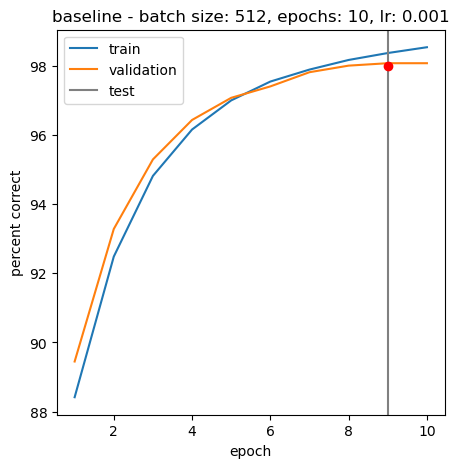

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 512, number of epochs 10, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 69.0 Val 70.4
adam Epoch 2 % Correct: Train 79.4 Val 81.1
adam Epoch 3 % Correct: Train 83.1 Val 85.4
adam Epoch 4 % Correct: Train 85.5 Val 87.4
adam Epoch 5 % Correct: Train 86.9 Val 88.7
adam Epoch 6 % Correct: Train 88.0 Val 89.3
adam Epoch 7 % Correct: Train 88.8 Val 90.0
adam Epoch 8 % Correct: Train 89.5 Val 90.6
adam Epoch 9 % Correct: Train 90.0 Val 91.2
adam Epoch 10 % Correct: Train 90.6 Val 91.7
baseline - batch size: 512, epochs: 10, lr: 0.0001: % correct: train 90.6 val 91.7 test 91.3


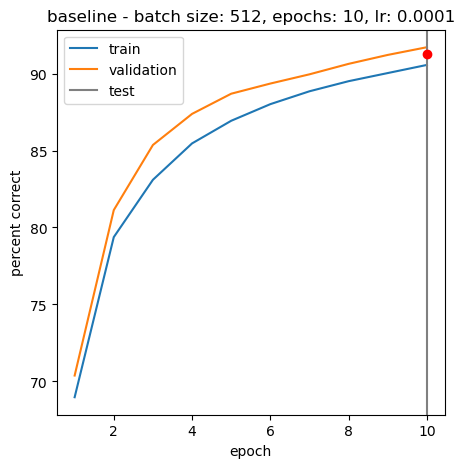

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 512, number of epochs 20, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 96.1 Val 96.1
adam Epoch 4 % Correct: Train 97.1 Val 96.7
adam Epoch 6 % Correct: Train 97.3 Val 97.1
adam Epoch 8 % Correct: Train 97.3 Val 97.1
adam Epoch 10 % Correct: Train 97.0 Val 96.7
adam Epoch 12 % Correct: Train 97.2 Val 97.0
adam Epoch 14 % Correct: Train 97.2 Val 96.9
adam Epoch 16 % Correct: Train 97.0 Val 96.5
adam Epoch 18 % Correct: Train 96.9 Val 96.7
adam Epoch 20 % Correct: Train 97.1 Val 96.6
baseline - batch size: 512, epochs: 20, lr: 0.01: % correct: train 97.3 val 97.1 test 96.9


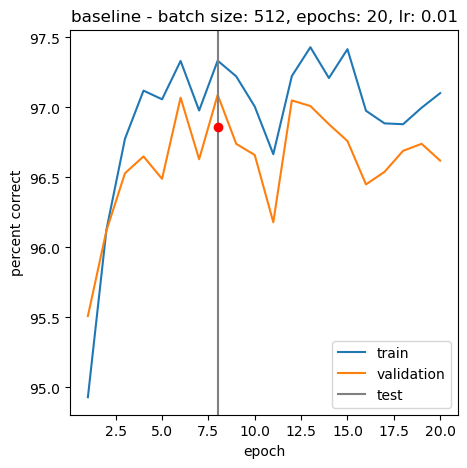

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 512, number of epochs 20, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 93.3 Val 94.2
adam Epoch 4 % Correct: Train 96.2 Val 96.5
adam Epoch 6 % Correct: Train 97.4 Val 97.4
adam Epoch 8 % Correct: Train 98.0 Val 97.7
adam Epoch 10 % Correct: Train 98.4 Val 98.1
adam Epoch 12 % Correct: Train 98.8 Val 98.2
adam Epoch 14 % Correct: Train 99.0 Val 98.3
adam Epoch 16 % Correct: Train 99.2 Val 98.3
adam Epoch 18 % Correct: Train 99.4 Val 98.3
adam Epoch 20 % Correct: Train 99.4 Val 98.5
baseline - batch size: 512, epochs: 20, lr: 0.001: % correct: train 99.4 val 98.5 test 98.4


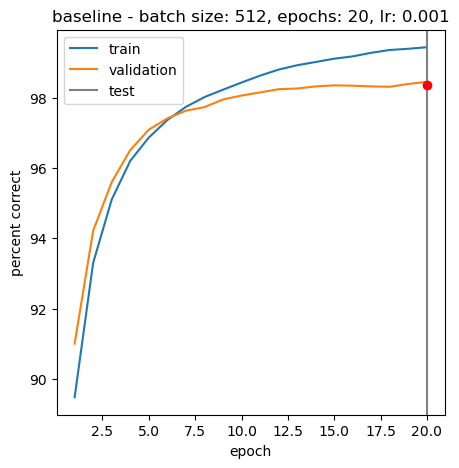

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 512, number of epochs 20, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 78.5 Val 80.6
adam Epoch 4 % Correct: Train 85.2 Val 87.5
adam Epoch 6 % Correct: Train 87.8 Val 89.4
adam Epoch 8 % Correct: Train 89.4 Val 90.7
adam Epoch 10 % Correct: Train 90.6 Val 91.7
adam Epoch 12 % Correct: Train 91.5 Val 92.6
adam Epoch 14 % Correct: Train 92.3 Val 93.4
adam Epoch 16 % Correct: Train 93.0 Val 94.1
adam Epoch 18 % Correct: Train 93.6 Val 94.6
adam Epoch 20 % Correct: Train 94.1 Val 95.1
baseline - batch size: 512, epochs: 20, lr: 0.0001: % correct: train 94.1 val 95.1 test 94.7


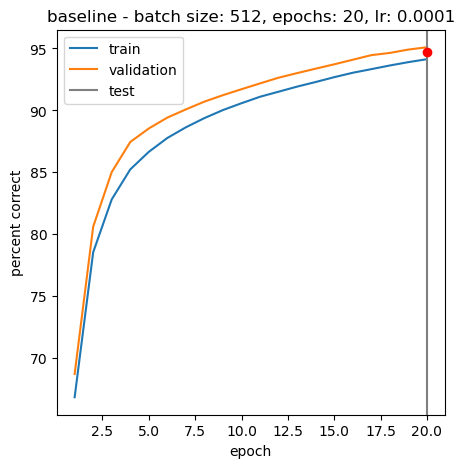

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 512, number of epochs 30, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 96.8 Val 96.7
adam Epoch 6 % Correct: Train 96.7 Val 96.6
adam Epoch 9 % Correct: Train 97.2 Val 96.9
adam Epoch 12 % Correct: Train 97.3 Val 97.0
adam Epoch 15 % Correct: Train 97.5 Val 97.2
adam Epoch 18 % Correct: Train 97.5 Val 97.3
adam Epoch 21 % Correct: Train 97.2 Val 97.1
adam Epoch 24 % Correct: Train 97.3 Val 96.7
adam Epoch 27 % Correct: Train 97.0 Val 96.7
adam Epoch 30 % Correct: Train 97.8 Val 97.4
baseline - batch size: 512, epochs: 30, lr: 0.01: % correct: train 97.5 val 97.4 test 97.1


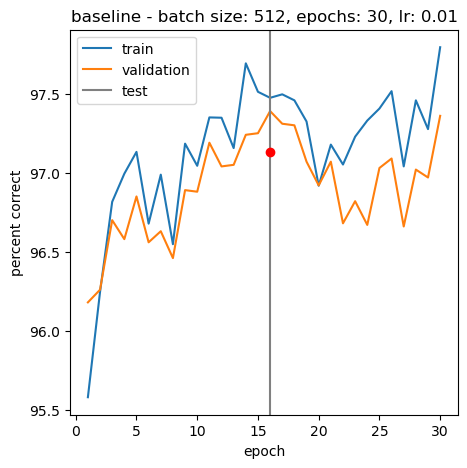

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 512, number of epochs 30, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 94.9 Val 95.4
adam Epoch 6 % Correct: Train 97.4 Val 97.3
adam Epoch 9 % Correct: Train 98.3 Val 97.9
adam Epoch 12 % Correct: Train 98.7 Val 98.1
adam Epoch 15 % Correct: Train 99.1 Val 98.2
adam Epoch 18 % Correct: Train 99.3 Val 98.2
adam Epoch 21 % Correct: Train 99.5 Val 98.4
adam Epoch 24 % Correct: Train 99.5 Val 98.4
adam Epoch 27 % Correct: Train 99.6 Val 98.4
adam Epoch 30 % Correct: Train 99.7 Val 98.4
baseline - batch size: 512, epochs: 30, lr: 0.001: % correct: train 99.5 val 98.4 test 98.6


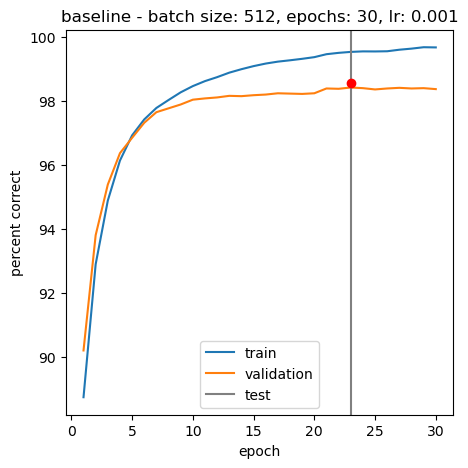

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 512, number of epochs 30, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 82.7 Val 84.7
adam Epoch 6 % Correct: Train 87.4 Val 89.1
adam Epoch 9 % Correct: Train 89.6 Val 91.1
adam Epoch 12 % Correct: Train 91.1 Val 92.4
adam Epoch 15 % Correct: Train 92.3 Val 93.3
adam Epoch 18 % Correct: Train 93.2 Val 94.2
adam Epoch 21 % Correct: Train 94.1 Val 94.9
adam Epoch 24 % Correct: Train 94.9 Val 95.5
adam Epoch 27 % Correct: Train 95.5 Val 95.8
adam Epoch 30 % Correct: Train 95.9 Val 96.3
baseline - batch size: 512, epochs: 30, lr: 0.0001: % correct: train 95.9 val 96.3 test 96.0


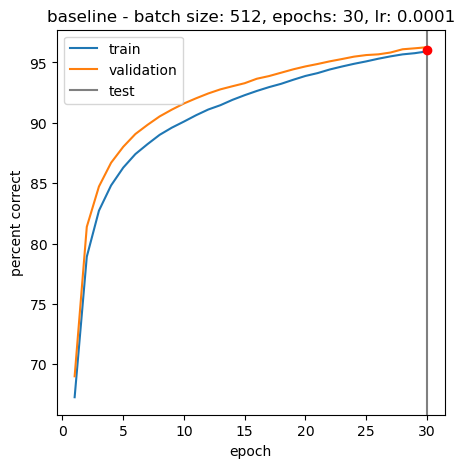

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 1024, number of epochs 10, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 93.7 Val 94.4
adam Epoch 2 % Correct: Train 96.5 Val 96.6
adam Epoch 3 % Correct: Train 97.6 Val 97.2
adam Epoch 4 % Correct: Train 98.0 Val 97.5
adam Epoch 5 % Correct: Train 97.9 Val 97.5
adam Epoch 6 % Correct: Train 98.1 Val 97.4
adam Epoch 7 % Correct: Train 98.4 Val 97.7
adam Epoch 8 % Correct: Train 98.4 Val 97.6
adam Epoch 9 % Correct: Train 98.4 Val 97.6
adam Epoch 10 % Correct: Train 98.2 Val 97.4
baseline - batch size: 1024, epochs: 10, lr: 0.01: % correct: train 98.4 val 97.7 test 97.5


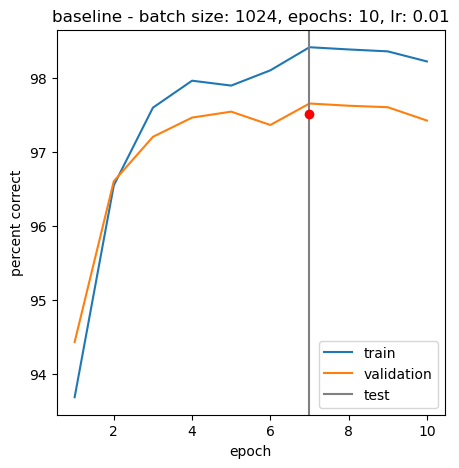

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 1024, number of epochs 10, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 85.4 Val 87.7
adam Epoch 2 % Correct: Train 89.9 Val 91.5
adam Epoch 3 % Correct: Train 92.4 Val 93.7
adam Epoch 4 % Correct: Train 94.1 Val 95.3
adam Epoch 5 % Correct: Train 95.2 Val 95.9
adam Epoch 6 % Correct: Train 95.9 Val 96.5
adam Epoch 7 % Correct: Train 96.5 Val 96.8
adam Epoch 8 % Correct: Train 96.9 Val 97.1
adam Epoch 9 % Correct: Train 97.2 Val 97.4
adam Epoch 10 % Correct: Train 97.5 Val 97.6
baseline - batch size: 1024, epochs: 10, lr: 0.001: % correct: train 97.5 val 97.6 test 97.2


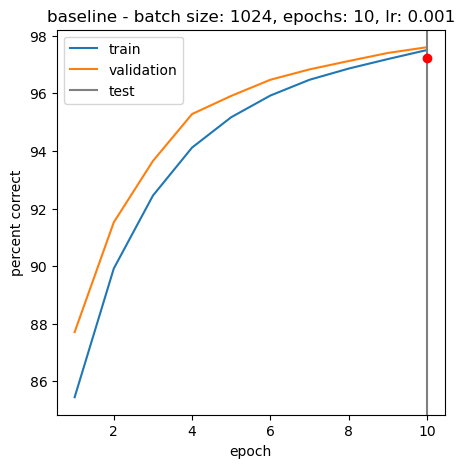

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 1024, number of epochs 10, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 53.1 Val 55.2
adam Epoch 2 % Correct: Train 66.2 Val 68.2
adam Epoch 3 % Correct: Train 73.2 Val 75.4
adam Epoch 4 % Correct: Train 77.2 Val 79.5
adam Epoch 5 % Correct: Train 79.8 Val 82.2
adam Epoch 6 % Correct: Train 81.7 Val 84.2
adam Epoch 7 % Correct: Train 83.2 Val 85.5
adam Epoch 8 % Correct: Train 84.4 Val 86.3
adam Epoch 9 % Correct: Train 85.3 Val 87.1
adam Epoch 10 % Correct: Train 86.0 Val 87.7
baseline - batch size: 1024, epochs: 10, lr: 0.0001: % correct: train 86.0 val 87.7 test 87.0


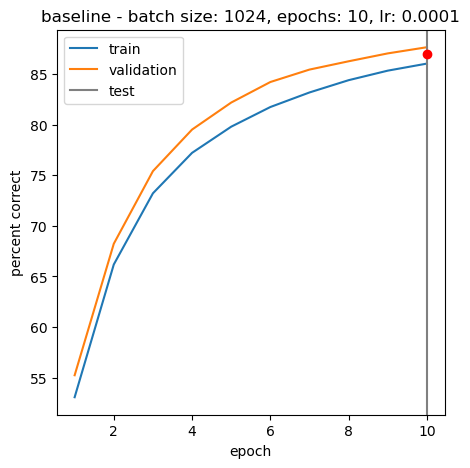

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 1024, number of epochs 20, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 96.5 Val 96.4
adam Epoch 4 % Correct: Train 97.7 Val 97.4
adam Epoch 6 % Correct: Train 98.0 Val 97.4
adam Epoch 8 % Correct: Train 98.3 Val 97.5
adam Epoch 10 % Correct: Train 98.6 Val 97.7
adam Epoch 12 % Correct: Train 98.1 Val 97.3
adam Epoch 14 % Correct: Train 98.6 Val 97.6
adam Epoch 16 % Correct: Train 98.4 Val 97.5
adam Epoch 18 % Correct: Train 98.3 Val 97.5
adam Epoch 20 % Correct: Train 98.5 Val 97.7
baseline - batch size: 1024, epochs: 20, lr: 0.01: % correct: train 98.7 val 97.7 test 97.9


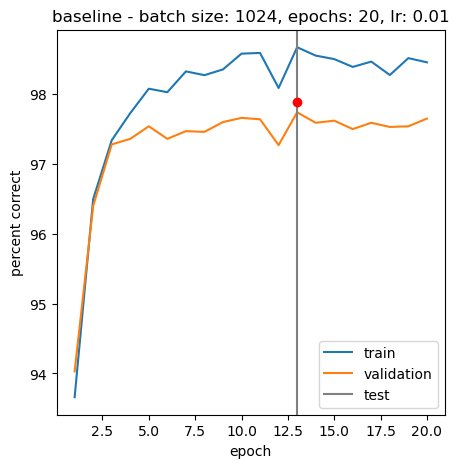

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 1024, number of epochs 20, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 88.9 Val 90.2
adam Epoch 4 % Correct: Train 93.4 Val 94.2
adam Epoch 6 % Correct: Train 95.6 Val 96.3
adam Epoch 8 % Correct: Train 96.7 Val 97.1
adam Epoch 10 % Correct: Train 97.4 Val 97.6
adam Epoch 12 % Correct: Train 97.9 Val 97.8
adam Epoch 14 % Correct: Train 98.3 Val 98.0
adam Epoch 16 % Correct: Train 98.5 Val 98.1
adam Epoch 18 % Correct: Train 98.7 Val 98.2
adam Epoch 20 % Correct: Train 98.9 Val 98.3
baseline - batch size: 1024, epochs: 20, lr: 0.001: % correct: train 98.9 val 98.3 test 98.1


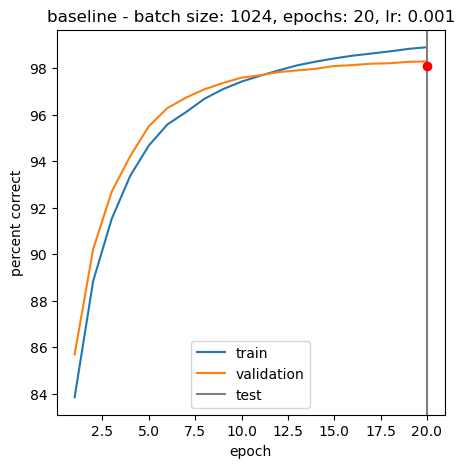

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 1024, number of epochs 20, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 60.1 Val 62.6
adam Epoch 4 % Correct: Train 74.2 Val 77.1
adam Epoch 6 % Correct: Train 80.6 Val 83.0
adam Epoch 8 % Correct: Train 84.1 Val 86.3
adam Epoch 10 % Correct: Train 86.2 Val 88.2
adam Epoch 12 % Correct: Train 87.5 Val 89.2
adam Epoch 14 % Correct: Train 88.4 Val 89.9
adam Epoch 16 % Correct: Train 89.3 Val 90.4
adam Epoch 18 % Correct: Train 89.9 Val 91.1
adam Epoch 20 % Correct: Train 90.5 Val 91.6
baseline - batch size: 1024, epochs: 20, lr: 0.0001: % correct: train 90.5 val 91.6 test 91.3


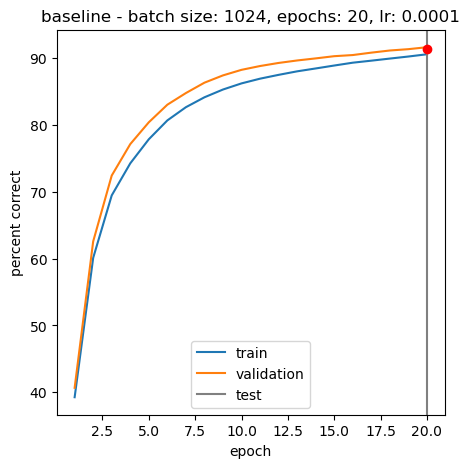

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 1024, number of epochs 30, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 97.6 Val 97.3
adam Epoch 6 % Correct: Train 97.9 Val 97.4
adam Epoch 9 % Correct: Train 98.5 Val 97.6
adam Epoch 12 % Correct: Train 98.4 Val 97.4
adam Epoch 15 % Correct: Train 98.5 Val 97.9
adam Epoch 18 % Correct: Train 98.4 Val 97.5
adam Epoch 21 % Correct: Train 98.3 Val 97.7
adam Epoch 24 % Correct: Train 98.5 Val 97.5
adam Epoch 27 % Correct: Train 98.5 Val 97.8
adam Epoch 30 % Correct: Train 98.2 Val 97.4
baseline - batch size: 1024, epochs: 30, lr: 0.01: % correct: train 98.5 val 97.9 test 97.6


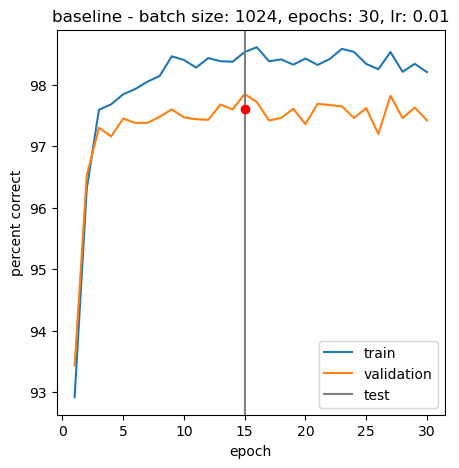

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 1024, number of epochs 30, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 90.9 Val 91.7
adam Epoch 6 % Correct: Train 94.9 Val 95.3
adam Epoch 9 % Correct: Train 96.9 Val 97.1
adam Epoch 12 % Correct: Train 97.8 Val 97.7
adam Epoch 15 % Correct: Train 98.4 Val 98.0
adam Epoch 18 % Correct: Train 98.8 Val 98.2
adam Epoch 21 % Correct: Train 99.0 Val 98.2
adam Epoch 24 % Correct: Train 99.2 Val 98.4
adam Epoch 27 % Correct: Train 99.4 Val 98.4
adam Epoch 30 % Correct: Train 99.5 Val 98.4
baseline - batch size: 1024, epochs: 30, lr: 0.001: % correct: train 99.5 val 98.4 test 98.5


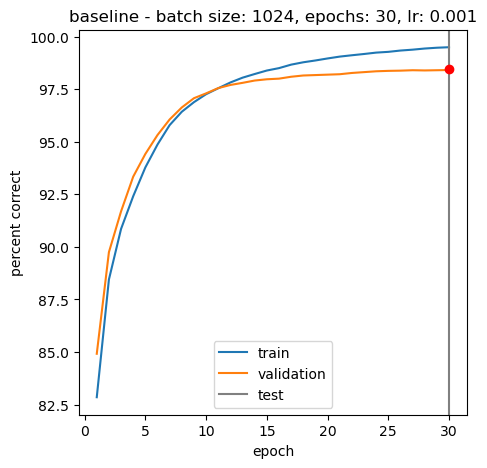

Percent Correct (Actual class in rows, Predicted class in columns)


Testing baseline with batch size 1024, number of epochs 30, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 73.0 Val 75.7
adam Epoch 6 % Correct: Train 80.4 Val 82.5
adam Epoch 9 % Correct: Train 83.6 Val 85.4
adam Epoch 12 % Correct: Train 85.7 Val 87.1
adam Epoch 15 % Correct: Train 87.4 Val 88.7
adam Epoch 18 % Correct: Train 88.9 Val 90.1
adam Epoch 21 % Correct: Train 90.1 Val 91.2
adam Epoch 24 % Correct: Train 91.1 Val 92.1
adam Epoch 27 % Correct: Train 91.9 Val 93.0
adam Epoch 30 % Correct: Train 92.7 Val 93.7
baseline - batch size: 1024, epochs: 30, lr: 0.0001: % correct: train 92.7 val 93.7 test 93.3


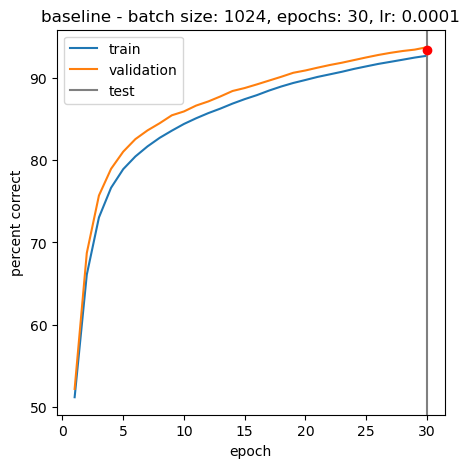

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 256, number of epochs 10, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 96.1 Val 96.3
adam Epoch 2 % Correct: Train 97.1 Val 97.0
adam Epoch 3 % Correct: Train 97.5 Val 97.1
adam Epoch 4 % Correct: Train 97.2 Val 96.8
adam Epoch 5 % Correct: Train 97.3 Val 97.0
adam Epoch 6 % Correct: Train 97.0 Val 96.6
adam Epoch 7 % Correct: Train 96.7 Val 96.4
adam Epoch 8 % Correct: Train 97.1 Val 96.7
adam Epoch 9 % Correct: Train 97.2 Val 96.8
adam Epoch 10 % Correct: Train 97.4 Val 96.9
no fully conected - batch size: 256, epochs: 10, lr: 0.01: % correct: train 97.5 val 97.1 test 97.1


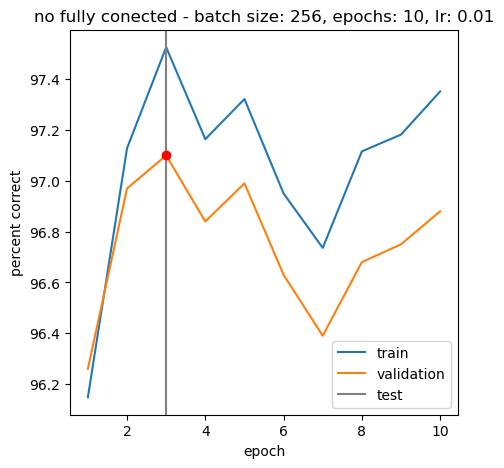

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 256, number of epochs 10, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 91.9 Val 93.0
adam Epoch 2 % Correct: Train 94.5 Val 95.4
adam Epoch 3 % Correct: Train 95.9 Val 96.4
adam Epoch 4 % Correct: Train 96.7 Val 96.8
adam Epoch 5 % Correct: Train 97.3 Val 97.2
adam Epoch 6 % Correct: Train 97.7 Val 97.4
adam Epoch 7 % Correct: Train 98.0 Val 97.6
adam Epoch 8 % Correct: Train 98.2 Val 97.8
adam Epoch 9 % Correct: Train 98.4 Val 97.9
adam Epoch 10 % Correct: Train 98.6 Val 97.9
no fully conected - batch size: 256, epochs: 10, lr: 0.001: % correct: train 98.6 val 97.9 test 98.2


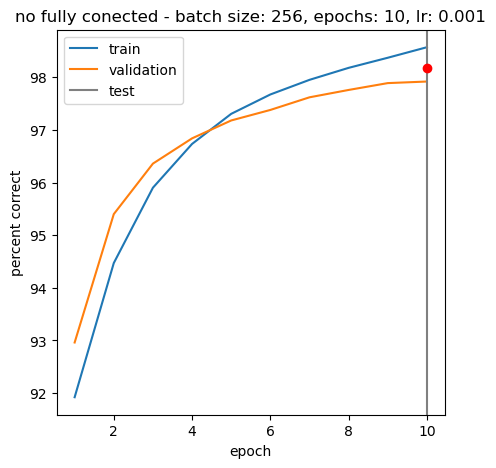

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 256, number of epochs 10, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 80.7 Val 83.7
adam Epoch 2 % Correct: Train 86.3 Val 88.2
adam Epoch 3 % Correct: Train 88.1 Val 89.8
adam Epoch 4 % Correct: Train 89.1 Val 90.5
adam Epoch 5 % Correct: Train 90.0 Val 91.2
adam Epoch 6 % Correct: Train 90.6 Val 91.8
adam Epoch 7 % Correct: Train 91.2 Val 92.4
adam Epoch 8 % Correct: Train 91.7 Val 92.8
adam Epoch 9 % Correct: Train 92.1 Val 93.2
adam Epoch 10 % Correct: Train 92.5 Val 93.5
no fully conected - batch size: 256, epochs: 10, lr: 0.0001: % correct: train 92.5 val 93.5 test 93.4


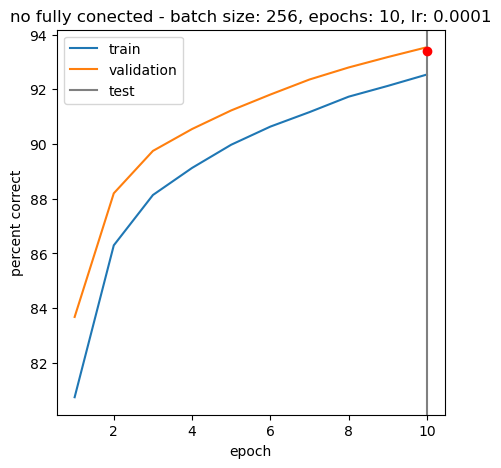

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 256, number of epochs 20, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 97.2 Val 97.2
adam Epoch 4 % Correct: Train 97.1 Val 97.0
adam Epoch 6 % Correct: Train 97.0 Val 96.6
adam Epoch 8 % Correct: Train 97.6 Val 97.3
adam Epoch 10 % Correct: Train 96.9 Val 96.7
adam Epoch 12 % Correct: Train 97.5 Val 97.0
adam Epoch 14 % Correct: Train 97.2 Val 96.9
adam Epoch 16 % Correct: Train 97.7 Val 97.1
adam Epoch 18 % Correct: Train 97.7 Val 97.2
adam Epoch 20 % Correct: Train 97.5 Val 97.2
no fully conected - batch size: 256, epochs: 20, lr: 0.01: % correct: train 97.4 val 97.3 test 97.2


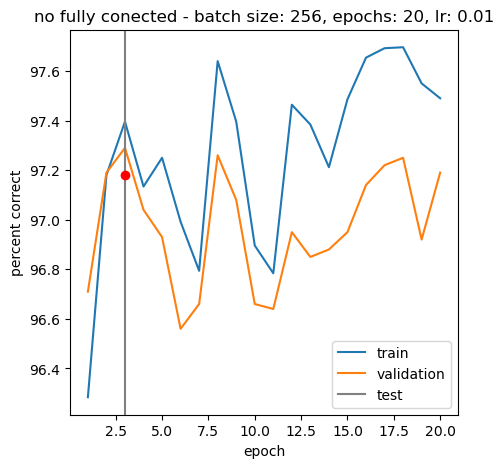

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 256, number of epochs 20, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 94.4 Val 95.2
adam Epoch 4 % Correct: Train 96.6 Val 97.0
adam Epoch 6 % Correct: Train 97.6 Val 97.4
adam Epoch 8 % Correct: Train 98.2 Val 97.8
adam Epoch 10 % Correct: Train 98.6 Val 98.0
adam Epoch 12 % Correct: Train 98.9 Val 98.1
adam Epoch 14 % Correct: Train 99.1 Val 98.1
adam Epoch 16 % Correct: Train 99.2 Val 98.2
adam Epoch 18 % Correct: Train 99.3 Val 98.2
adam Epoch 20 % Correct: Train 99.4 Val 98.2
no fully conected - batch size: 256, epochs: 20, lr: 0.001: % correct: train 99.4 val 98.2 test 98.4


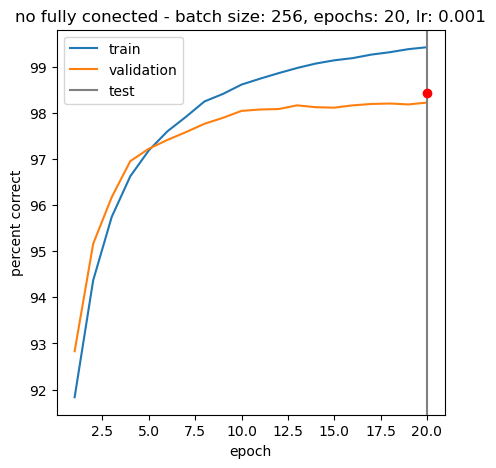

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 256, number of epochs 20, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 85.2 Val 87.2
adam Epoch 4 % Correct: Train 88.7 Val 90.3
adam Epoch 6 % Correct: Train 90.3 Val 91.8
adam Epoch 8 % Correct: Train 91.5 Val 92.7
adam Epoch 10 % Correct: Train 92.4 Val 93.5
adam Epoch 12 % Correct: Train 93.1 Val 94.1
adam Epoch 14 % Correct: Train 93.7 Val 94.6
adam Epoch 16 % Correct: Train 94.2 Val 95.0
adam Epoch 18 % Correct: Train 94.6 Val 95.3
adam Epoch 20 % Correct: Train 95.0 Val 95.6
no fully conected - batch size: 256, epochs: 20, lr: 0.0001: % correct: train 95.0 val 95.6 test 95.2


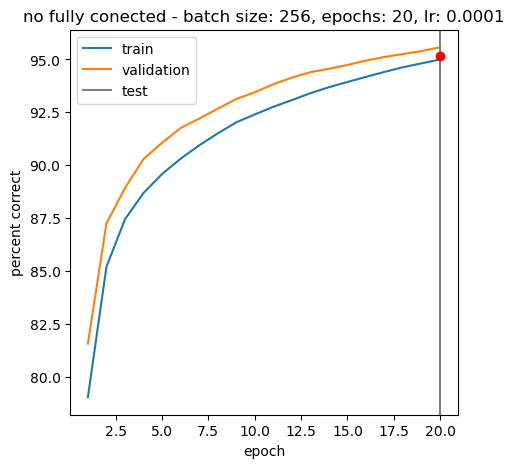

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 256, number of epochs 30, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 97.0 Val 96.8
adam Epoch 6 % Correct: Train 97.1 Val 96.6
adam Epoch 9 % Correct: Train 97.4 Val 97.2
adam Epoch 12 % Correct: Train 96.9 Val 96.6
adam Epoch 15 % Correct: Train 97.2 Val 96.9
adam Epoch 18 % Correct: Train 97.2 Val 96.5
adam Epoch 21 % Correct: Train 97.8 Val 97.1
adam Epoch 24 % Correct: Train 97.4 Val 96.9
adam Epoch 27 % Correct: Train 97.4 Val 97.0
adam Epoch 30 % Correct: Train 98.0 Val 97.4
no fully conected - batch size: 256, epochs: 30, lr: 0.01: % correct: train 98.0 val 97.4 test 97.3


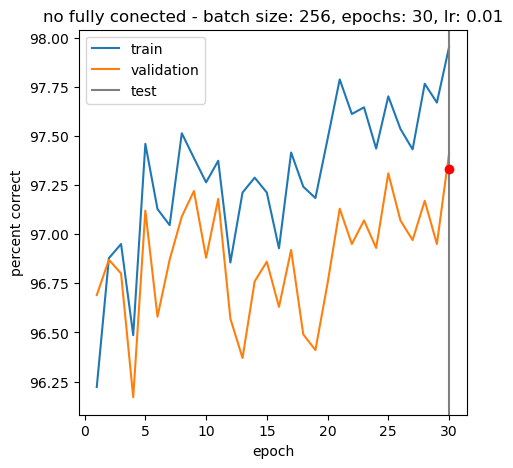

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 256, number of epochs 30, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 95.7 Val 96.2
adam Epoch 6 % Correct: Train 97.6 Val 97.5
adam Epoch 9 % Correct: Train 98.4 Val 98.0
adam Epoch 12 % Correct: Train 98.9 Val 98.2
adam Epoch 15 % Correct: Train 99.2 Val 98.3
adam Epoch 18 % Correct: Train 99.4 Val 98.3
adam Epoch 21 % Correct: Train 99.5 Val 98.3
adam Epoch 24 % Correct: Train 99.6 Val 98.4
adam Epoch 27 % Correct: Train 99.7 Val 98.4
adam Epoch 30 % Correct: Train 99.8 Val 98.4
no fully conected - batch size: 256, epochs: 30, lr: 0.001: % correct: train 99.7 val 98.4 test 98.5


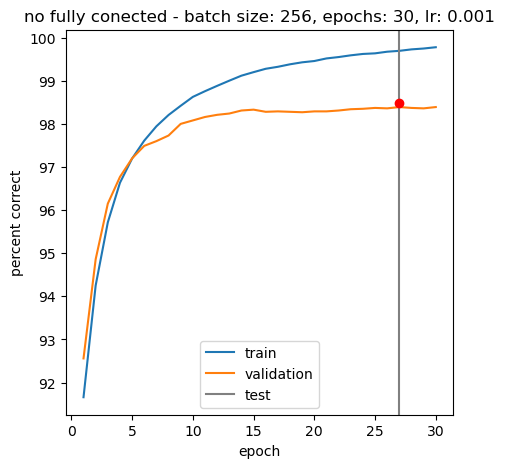

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 256, number of epochs 30, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 88.2 Val 89.7
adam Epoch 6 % Correct: Train 90.8 Val 92.0
adam Epoch 9 % Correct: Train 92.3 Val 93.3
adam Epoch 12 % Correct: Train 93.5 Val 94.3
adam Epoch 15 % Correct: Train 94.3 Val 95.0
adam Epoch 18 % Correct: Train 94.9 Val 95.7
adam Epoch 21 % Correct: Train 95.5 Val 96.1
adam Epoch 24 % Correct: Train 96.0 Val 96.5
adam Epoch 27 % Correct: Train 96.5 Val 96.9
adam Epoch 30 % Correct: Train 96.9 Val 97.2
no fully conected - batch size: 256, epochs: 30, lr: 0.0001: % correct: train 96.9 val 97.2 test 97.0


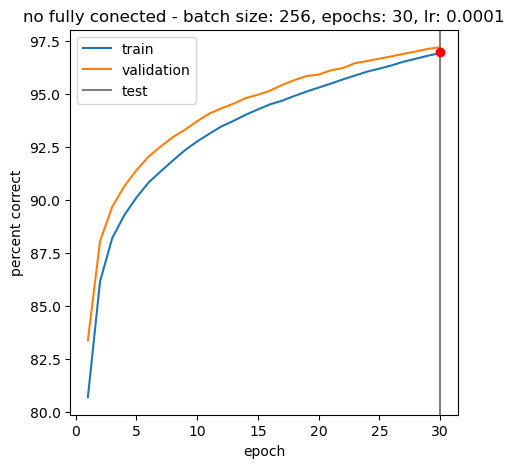

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 512, number of epochs 10, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 95.6 Val 95.9
adam Epoch 2 % Correct: Train 97.3 Val 97.2
adam Epoch 3 % Correct: Train 97.3 Val 97.1
adam Epoch 4 % Correct: Train 98.0 Val 97.5
adam Epoch 5 % Correct: Train 98.0 Val 97.4
adam Epoch 6 % Correct: Train 97.9 Val 97.4
adam Epoch 7 % Correct: Train 98.0 Val 97.1
adam Epoch 8 % Correct: Train 98.1 Val 97.5
adam Epoch 9 % Correct: Train 97.7 Val 96.9
adam Epoch 10 % Correct: Train 98.2 Val 97.4
no fully conected - batch size: 512, epochs: 10, lr: 0.01: % correct: train 98.0 val 97.5 test 97.5


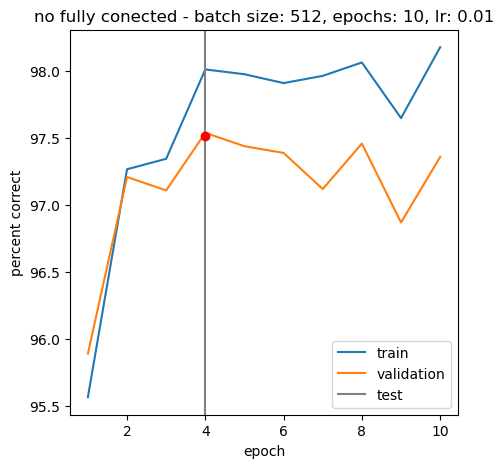

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 512, number of epochs 10, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 90.0 Val 91.1
adam Epoch 2 % Correct: Train 92.7 Val 93.5
adam Epoch 3 % Correct: Train 94.2 Val 94.9
adam Epoch 4 % Correct: Train 95.2 Val 95.7
adam Epoch 5 % Correct: Train 96.0 Val 96.5
adam Epoch 6 % Correct: Train 96.6 Val 96.9
adam Epoch 7 % Correct: Train 97.1 Val 97.1
adam Epoch 8 % Correct: Train 97.5 Val 97.3
adam Epoch 9 % Correct: Train 97.7 Val 97.5
adam Epoch 10 % Correct: Train 98.0 Val 97.7
no fully conected - batch size: 512, epochs: 10, lr: 0.001: % correct: train 98.0 val 97.7 test 97.8


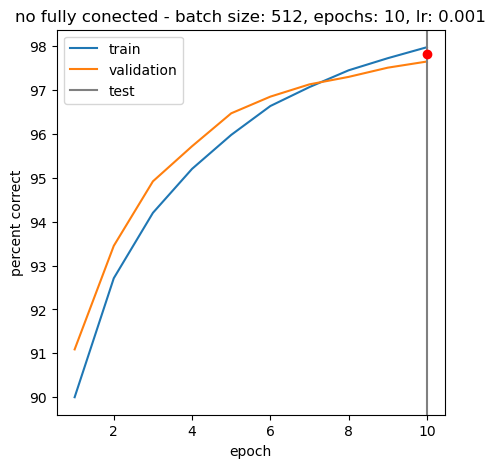

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 512, number of epochs 10, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 70.8 Val 73.7
adam Epoch 2 % Correct: Train 81.0 Val 83.7
adam Epoch 3 % Correct: Train 84.3 Val 86.6
adam Epoch 4 % Correct: Train 86.2 Val 88.0
adam Epoch 5 % Correct: Train 87.4 Val 89.1
adam Epoch 6 % Correct: Train 88.3 Val 89.8
adam Epoch 7 % Correct: Train 88.9 Val 90.4
adam Epoch 8 % Correct: Train 89.5 Val 90.9
adam Epoch 9 % Correct: Train 89.9 Val 91.3
adam Epoch 10 % Correct: Train 90.3 Val 91.6
no fully conected - batch size: 512, epochs: 10, lr: 0.0001: % correct: train 90.3 val 91.6 test 91.2


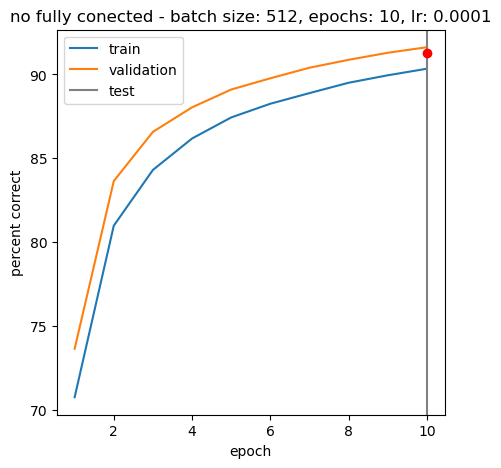

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 512, number of epochs 20, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 97.6 Val 97.4
adam Epoch 4 % Correct: Train 98.1 Val 97.6
adam Epoch 6 % Correct: Train 98.2 Val 97.7
adam Epoch 8 % Correct: Train 98.0 Val 97.4
adam Epoch 10 % Correct: Train 98.1 Val 97.8
adam Epoch 12 % Correct: Train 98.3 Val 97.5
adam Epoch 14 % Correct: Train 98.2 Val 97.5
adam Epoch 16 % Correct: Train 97.8 Val 96.9
adam Epoch 18 % Correct: Train 97.8 Val 97.1
adam Epoch 20 % Correct: Train 98.1 Val 97.5
no fully conected - batch size: 512, epochs: 20, lr: 0.01: % correct: train 98.1 val 97.8 test 97.5


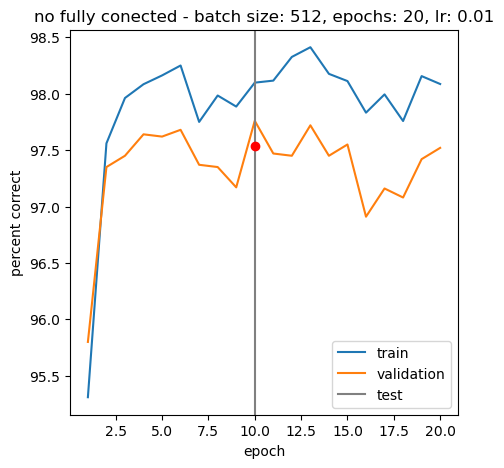

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 512, number of epochs 20, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 92.3 Val 93.3
adam Epoch 4 % Correct: Train 95.1 Val 95.7
adam Epoch 6 % Correct: Train 96.5 Val 96.9
adam Epoch 8 % Correct: Train 97.3 Val 97.4
adam Epoch 10 % Correct: Train 97.8 Val 97.7
adam Epoch 12 % Correct: Train 98.2 Val 97.9
adam Epoch 14 % Correct: Train 98.4 Val 98.0
adam Epoch 16 % Correct: Train 98.6 Val 98.1
adam Epoch 18 % Correct: Train 98.8 Val 98.2
adam Epoch 20 % Correct: Train 99.0 Val 98.3
no fully conected - batch size: 512, epochs: 20, lr: 0.001: % correct: train 99.0 val 98.3 test 98.4


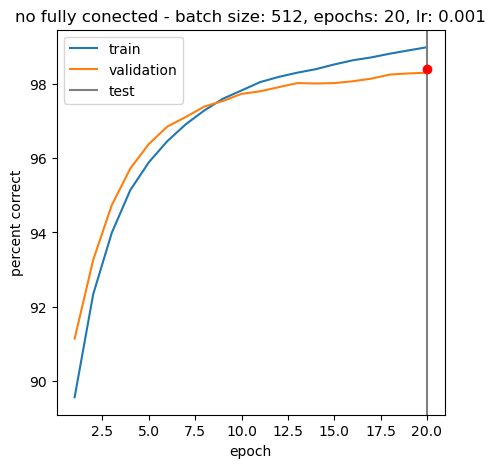

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 512, number of epochs 20, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 82.0 Val 84.5
adam Epoch 4 % Correct: Train 86.6 Val 88.3
adam Epoch 6 % Correct: Train 88.4 Val 89.7
adam Epoch 8 % Correct: Train 89.5 Val 90.9
adam Epoch 10 % Correct: Train 90.4 Val 91.8
adam Epoch 12 % Correct: Train 91.1 Val 92.3
adam Epoch 14 % Correct: Train 91.8 Val 92.9
adam Epoch 16 % Correct: Train 92.4 Val 93.3
adam Epoch 18 % Correct: Train 92.9 Val 93.7
adam Epoch 20 % Correct: Train 93.4 Val 94.2
no fully conected - batch size: 512, epochs: 20, lr: 0.0001: % correct: train 93.4 val 94.2 test 94.0


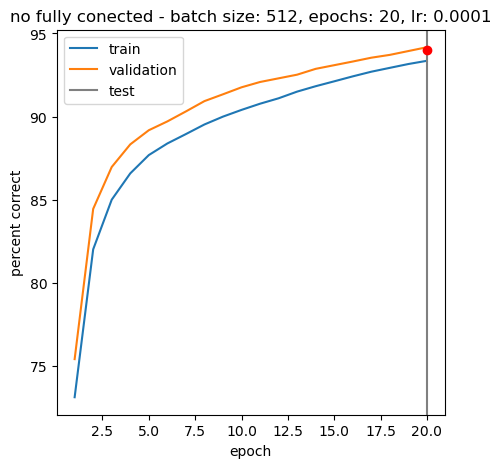

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 512, number of epochs 30, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 97.9 Val 97.5
adam Epoch 6 % Correct: Train 97.9 Val 97.5
adam Epoch 9 % Correct: Train 98.1 Val 97.4
adam Epoch 12 % Correct: Train 98.1 Val 97.2
adam Epoch 15 % Correct: Train 98.1 Val 97.3
adam Epoch 18 % Correct: Train 97.9 Val 97.2
adam Epoch 21 % Correct: Train 98.6 Val 97.6
adam Epoch 24 % Correct: Train 98.1 Val 97.3
adam Epoch 27 % Correct: Train 98.2 Val 97.3
adam Epoch 30 % Correct: Train 98.4 Val 97.6
no fully conected - batch size: 512, epochs: 30, lr: 0.01: % correct: train 98.6 val 97.8 test 98.0


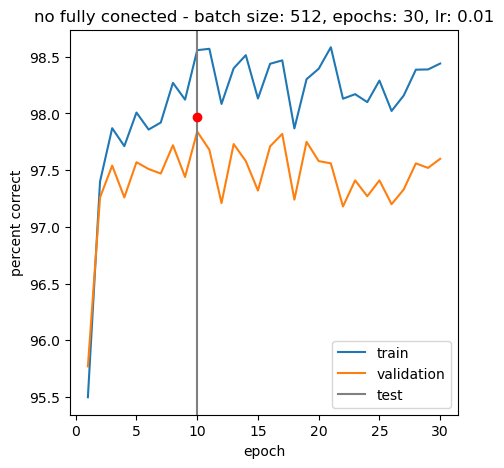

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 512, number of epochs 30, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 93.9 Val 94.5
adam Epoch 6 % Correct: Train 96.5 Val 96.8
adam Epoch 9 % Correct: Train 97.7 Val 97.5
adam Epoch 12 % Correct: Train 98.3 Val 98.1
adam Epoch 15 % Correct: Train 98.7 Val 98.3
adam Epoch 18 % Correct: Train 99.0 Val 98.4
adam Epoch 21 % Correct: Train 99.1 Val 98.5
adam Epoch 24 % Correct: Train 99.2 Val 98.5
adam Epoch 27 % Correct: Train 99.4 Val 98.5
adam Epoch 30 % Correct: Train 99.5 Val 98.6
no fully conected - batch size: 512, epochs: 30, lr: 0.001: % correct: train 99.5 val 98.6 test 98.7


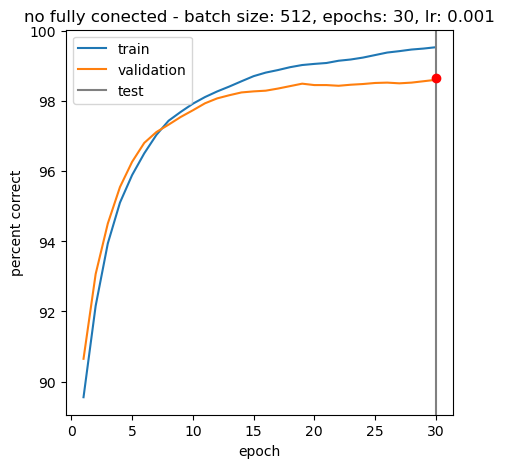

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 512, number of epochs 30, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 84.5 Val 86.9
adam Epoch 6 % Correct: Train 88.3 Val 90.2
adam Epoch 9 % Correct: Train 89.9 Val 91.5
adam Epoch 12 % Correct: Train 91.2 Val 92.4
adam Epoch 15 % Correct: Train 92.1 Val 93.2
adam Epoch 18 % Correct: Train 92.8 Val 93.8
adam Epoch 21 % Correct: Train 93.4 Val 94.4
adam Epoch 24 % Correct: Train 94.0 Val 94.9
adam Epoch 27 % Correct: Train 94.5 Val 95.1
adam Epoch 30 % Correct: Train 94.9 Val 95.4
no fully conected - batch size: 512, epochs: 30, lr: 0.0001: % correct: train 94.9 val 95.4 test 95.0


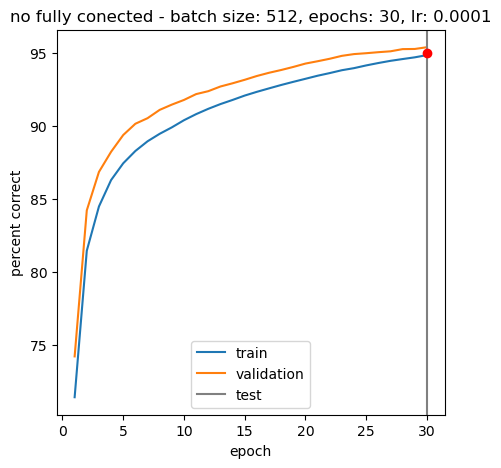

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 1024, number of epochs 10, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 93.8 Val 94.2
adam Epoch 2 % Correct: Train 96.5 Val 96.6
adam Epoch 3 % Correct: Train 97.5 Val 97.3
adam Epoch 4 % Correct: Train 97.9 Val 97.7
adam Epoch 5 % Correct: Train 98.1 Val 97.8
adam Epoch 6 % Correct: Train 98.4 Val 97.8
adam Epoch 7 % Correct: Train 98.6 Val 97.8
adam Epoch 8 % Correct: Train 98.8 Val 98.0
adam Epoch 9 % Correct: Train 98.8 Val 97.9
adam Epoch 10 % Correct: Train 98.7 Val 97.3
no fully conected - batch size: 1024, epochs: 10, lr: 0.01: % correct: train 98.8 val 98.0 test 97.9


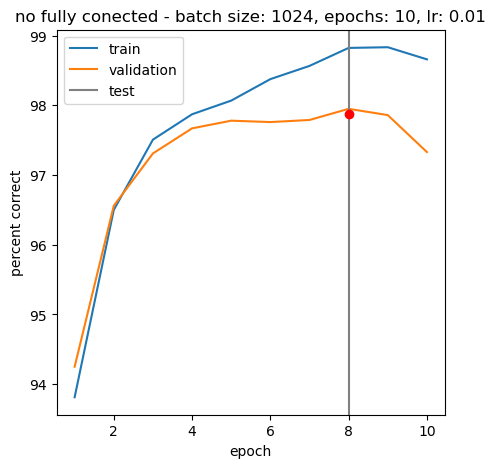

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 1024, number of epochs 10, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 86.7 Val 88.5
adam Epoch 2 % Correct: Train 90.3 Val 91.4
adam Epoch 3 % Correct: Train 91.9 Val 92.8
adam Epoch 4 % Correct: Train 93.0 Val 93.9
adam Epoch 5 % Correct: Train 93.9 Val 94.8
adam Epoch 6 % Correct: Train 94.7 Val 95.4
adam Epoch 7 % Correct: Train 95.2 Val 96.0
adam Epoch 8 % Correct: Train 95.7 Val 96.4
adam Epoch 9 % Correct: Train 96.1 Val 96.7
adam Epoch 10 % Correct: Train 96.5 Val 96.9
no fully conected - batch size: 1024, epochs: 10, lr: 0.001: % correct: train 96.5 val 96.9 test 96.5


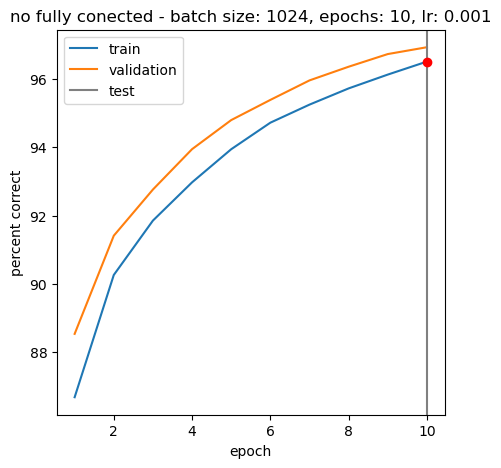

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 1024, number of epochs 10, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 60.3 Val 62.9
adam Epoch 2 % Correct: Train 70.7 Val 73.6
adam Epoch 3 % Correct: Train 77.8 Val 80.5
adam Epoch 4 % Correct: Train 81.3 Val 83.8
adam Epoch 5 % Correct: Train 83.4 Val 85.7
adam Epoch 6 % Correct: Train 84.9 Val 87.0
adam Epoch 7 % Correct: Train 85.9 Val 87.8
adam Epoch 8 % Correct: Train 86.7 Val 88.4
adam Epoch 9 % Correct: Train 87.3 Val 89.0
adam Epoch 10 % Correct: Train 87.9 Val 89.5
no fully conected - batch size: 1024, epochs: 10, lr: 0.0001: % correct: train 87.9 val 89.5 test 89.0


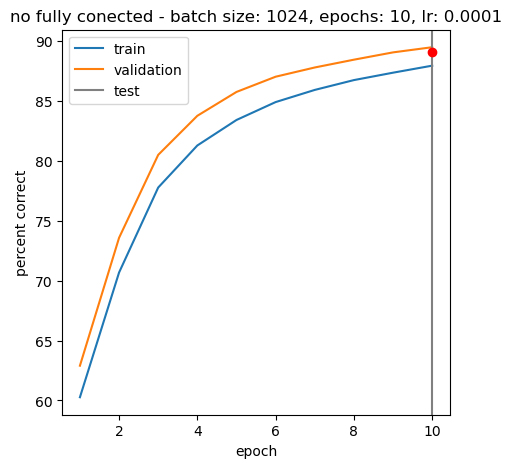

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 1024, number of epochs 20, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 96.7 Val 96.7
adam Epoch 4 % Correct: Train 98.0 Val 97.7
adam Epoch 6 % Correct: Train 98.5 Val 97.7
adam Epoch 8 % Correct: Train 98.8 Val 97.9
adam Epoch 10 % Correct: Train 99.0 Val 98.1
adam Epoch 12 % Correct: Train 99.0 Val 97.8
adam Epoch 14 % Correct: Train 99.0 Val 97.7
adam Epoch 16 % Correct: Train 99.1 Val 97.9
adam Epoch 18 % Correct: Train 99.1 Val 97.8
adam Epoch 20 % Correct: Train 99.2 Val 97.7
no fully conected - batch size: 1024, epochs: 20, lr: 0.01: % correct: train 99.0 val 98.1 test 98.1


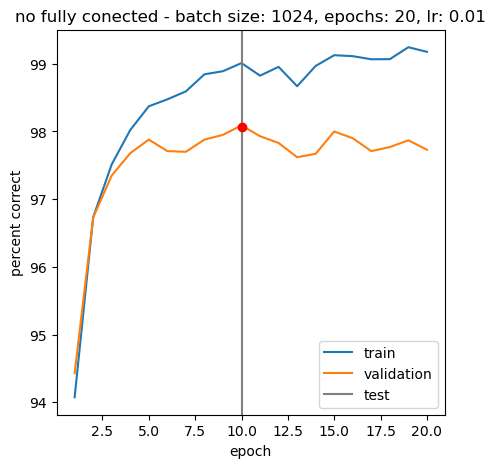

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 1024, number of epochs 20, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 90.0 Val 91.4
adam Epoch 4 % Correct: Train 93.0 Val 93.8
adam Epoch 6 % Correct: Train 94.7 Val 95.4
adam Epoch 8 % Correct: Train 95.8 Val 96.5
adam Epoch 10 % Correct: Train 96.8 Val 97.1
adam Epoch 12 % Correct: Train 97.4 Val 97.4
adam Epoch 14 % Correct: Train 97.8 Val 97.7
adam Epoch 16 % Correct: Train 98.1 Val 97.8
adam Epoch 18 % Correct: Train 98.3 Val 98.0
adam Epoch 20 % Correct: Train 98.5 Val 98.2
no fully conected - batch size: 1024, epochs: 20, lr: 0.001: % correct: train 98.5 val 98.2 test 98.2


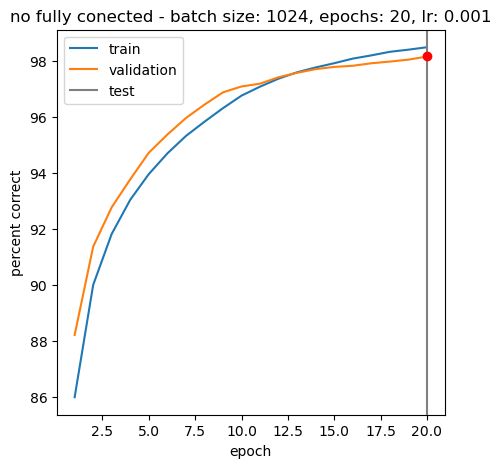

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 1024, number of epochs 20, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 71.2 Val 73.8
adam Epoch 4 % Correct: Train 82.3 Val 85.1
adam Epoch 6 % Correct: Train 85.8 Val 88.0
adam Epoch 8 % Correct: Train 87.3 Val 89.3
adam Epoch 10 % Correct: Train 88.3 Val 90.0
adam Epoch 12 % Correct: Train 89.1 Val 90.6
adam Epoch 14 % Correct: Train 89.7 Val 91.2
adam Epoch 16 % Correct: Train 90.2 Val 91.6
adam Epoch 18 % Correct: Train 90.7 Val 92.1
adam Epoch 20 % Correct: Train 91.2 Val 92.5
no fully conected - batch size: 1024, epochs: 20, lr: 0.0001: % correct: train 91.2 val 92.5 test 92.0


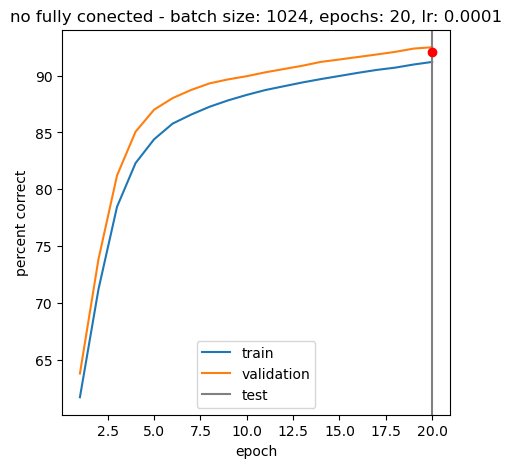

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 1024, number of epochs 30, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 97.5 Val 97.4
adam Epoch 6 % Correct: Train 98.4 Val 97.9
adam Epoch 9 % Correct: Train 98.8 Val 97.9
adam Epoch 12 % Correct: Train 99.1 Val 98.0
adam Epoch 15 % Correct: Train 99.2 Val 98.2
adam Epoch 18 % Correct: Train 99.1 Val 97.9
adam Epoch 21 % Correct: Train 99.1 Val 98.0
adam Epoch 24 % Correct: Train 99.3 Val 97.9
adam Epoch 27 % Correct: Train 99.0 Val 97.6
adam Epoch 30 % Correct: Train 98.8 Val 97.5
no fully conected - batch size: 1024, epochs: 30, lr: 0.01: % correct: train 99.2 val 98.2 test 98.0


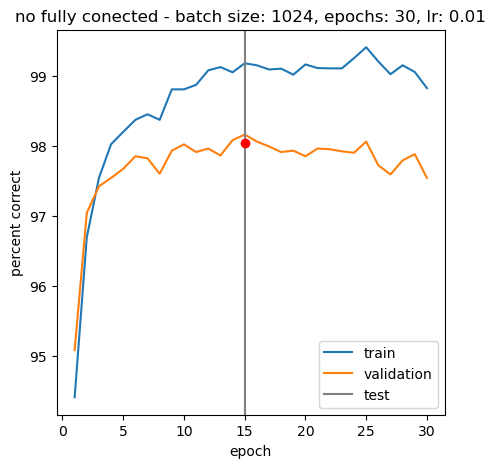

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 1024, number of epochs 30, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 91.8 Val 92.7
adam Epoch 6 % Correct: Train 94.6 Val 95.2
adam Epoch 9 % Correct: Train 96.2 Val 96.6
adam Epoch 12 % Correct: Train 97.2 Val 97.4
adam Epoch 15 % Correct: Train 97.9 Val 97.8
adam Epoch 18 % Correct: Train 98.3 Val 98.0
adam Epoch 21 % Correct: Train 98.5 Val 98.1
adam Epoch 24 % Correct: Train 98.7 Val 98.2
adam Epoch 27 % Correct: Train 98.9 Val 98.3
adam Epoch 30 % Correct: Train 99.0 Val 98.4
no fully conected - batch size: 1024, epochs: 30, lr: 0.001: % correct: train 99.0 val 98.4 test 98.4


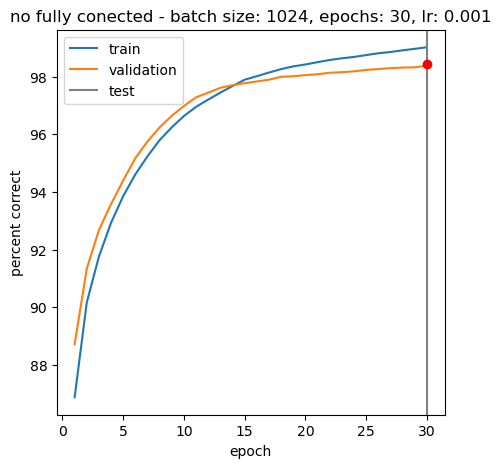

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no fully conected with batch size 1024, number of epochs 30, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 77.8 Val 80.7
adam Epoch 6 % Correct: Train 85.1 Val 87.4
adam Epoch 9 % Correct: Train 87.5 Val 89.6
adam Epoch 12 % Correct: Train 88.8 Val 90.7
adam Epoch 15 % Correct: Train 89.8 Val 91.4
adam Epoch 18 % Correct: Train 90.5 Val 92.0
adam Epoch 21 % Correct: Train 91.2 Val 92.5
adam Epoch 24 % Correct: Train 91.7 Val 92.9
adam Epoch 27 % Correct: Train 92.2 Val 93.3
adam Epoch 30 % Correct: Train 92.7 Val 93.6
no fully conected - batch size: 1024, epochs: 30, lr: 0.0001: % correct: train 92.7 val 93.6 test 93.2


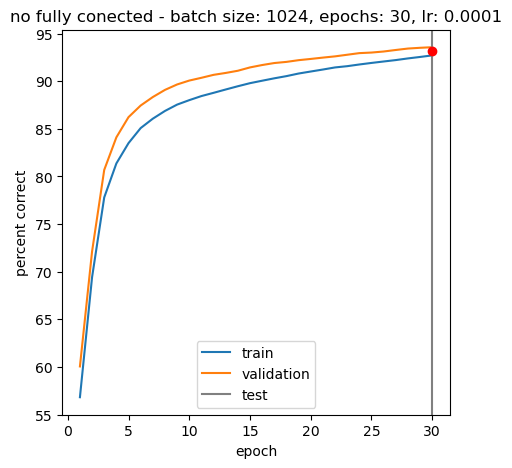

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 256, number of epochs 10, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 95.2 Val 94.3
adam Epoch 2 % Correct: Train 96.2 Val 95.2
adam Epoch 3 % Correct: Train 96.7 Val 95.1
adam Epoch 4 % Correct: Train 96.6 Val 95.1
adam Epoch 5 % Correct: Train 97.3 Val 95.5
adam Epoch 6 % Correct: Train 96.9 Val 95.1
adam Epoch 7 % Correct: Train 97.3 Val 95.4
adam Epoch 8 % Correct: Train 97.5 Val 95.3
adam Epoch 9 % Correct: Train 97.5 Val 95.4
adam Epoch 10 % Correct: Train 97.6 Val 95.4
no convolutional - batch size: 256, epochs: 10, lr: 0.01: % correct: train 97.3 val 95.5 test 95.2


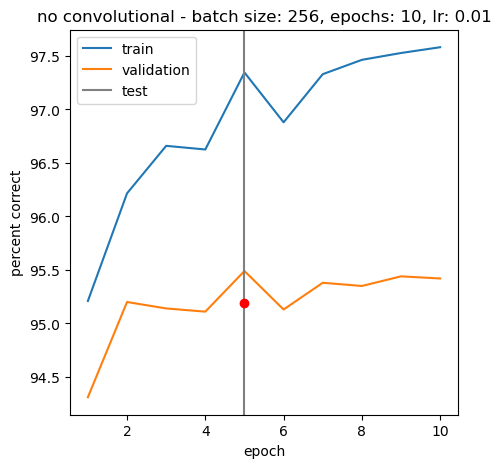

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 256, number of epochs 10, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 93.4 Val 93.6
adam Epoch 2 % Correct: Train 95.6 Val 95.0
adam Epoch 3 % Correct: Train 96.9 Val 95.5
adam Epoch 4 % Correct: Train 97.8 Val 96.2
adam Epoch 5 % Correct: Train 98.4 Val 96.5
adam Epoch 6 % Correct: Train 98.8 Val 96.5
adam Epoch 7 % Correct: Train 99.1 Val 96.5
adam Epoch 8 % Correct: Train 99.4 Val 96.7
adam Epoch 9 % Correct: Train 99.7 Val 96.9
adam Epoch 10 % Correct: Train 99.8 Val 96.8
no convolutional - batch size: 256, epochs: 10, lr: 0.001: % correct: train 99.7 val 96.9 test 96.2


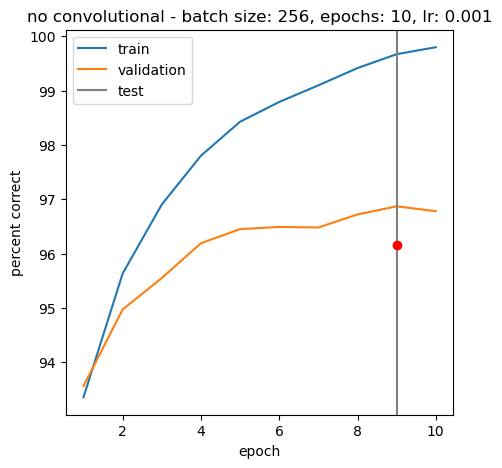

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 256, number of epochs 10, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 83.4 Val 85.2
adam Epoch 2 % Correct: Train 88.7 Val 89.9
adam Epoch 3 % Correct: Train 90.6 Val 91.3
adam Epoch 4 % Correct: Train 91.6 Val 92.1
adam Epoch 5 % Correct: Train 92.3 Val 92.7
adam Epoch 6 % Correct: Train 92.8 Val 93.2
adam Epoch 7 % Correct: Train 93.3 Val 93.5
adam Epoch 8 % Correct: Train 93.7 Val 93.9
adam Epoch 9 % Correct: Train 94.1 Val 94.2
adam Epoch 10 % Correct: Train 94.5 Val 94.5
no convolutional - batch size: 256, epochs: 10, lr: 0.0001: % correct: train 94.5 val 94.5 test 93.6


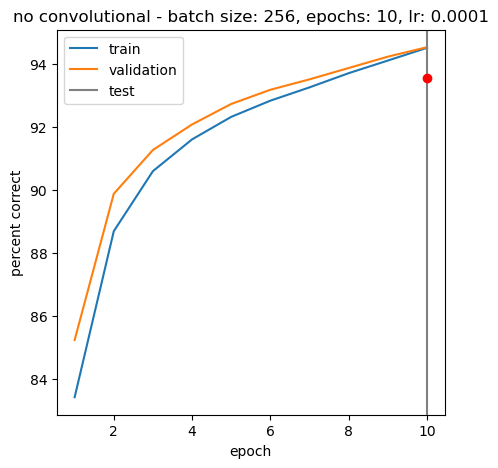

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 256, number of epochs 20, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 96.2 Val 95.2
adam Epoch 4 % Correct: Train 96.9 Val 95.8
adam Epoch 6 % Correct: Train 97.4 Val 95.4
adam Epoch 8 % Correct: Train 97.5 Val 95.5
adam Epoch 10 % Correct: Train 97.5 Val 95.8
adam Epoch 12 % Correct: Train 97.7 Val 95.6
adam Epoch 14 % Correct: Train 98.0 Val 95.4
adam Epoch 16 % Correct: Train 97.7 Val 95.5
adam Epoch 18 % Correct: Train 97.6 Val 95.0
adam Epoch 20 % Correct: Train 98.0 Val 95.8
no convolutional - batch size: 256, epochs: 20, lr: 0.01: % correct: train 98.2 val 95.8 test 95.2


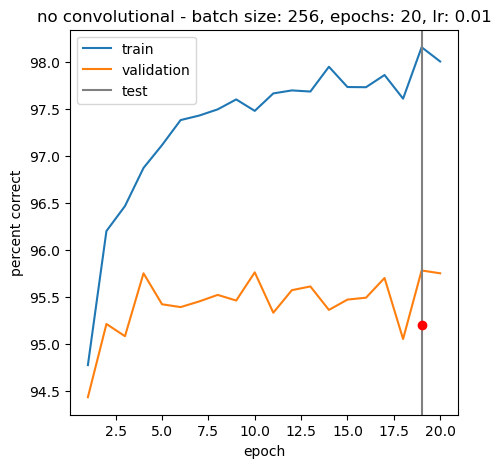

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 256, number of epochs 20, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 95.5 Val 95.0
adam Epoch 4 % Correct: Train 97.8 Val 96.3
adam Epoch 6 % Correct: Train 98.9 Val 96.8
adam Epoch 8 % Correct: Train 99.5 Val 96.7
adam Epoch 10 % Correct: Train 99.8 Val 96.8
adam Epoch 12 % Correct: Train 99.9 Val 96.9
adam Epoch 14 % Correct: Train 100.0 Val 96.9
adam Epoch 16 % Correct: Train 99.9 Val 96.5
adam Epoch 18 % Correct: Train 99.8 Val 96.5
adam Epoch 20 % Correct: Train 100.0 Val 96.9
no convolutional - batch size: 256, epochs: 20, lr: 0.001: % correct: train 100.0 val 96.9 test 96.6


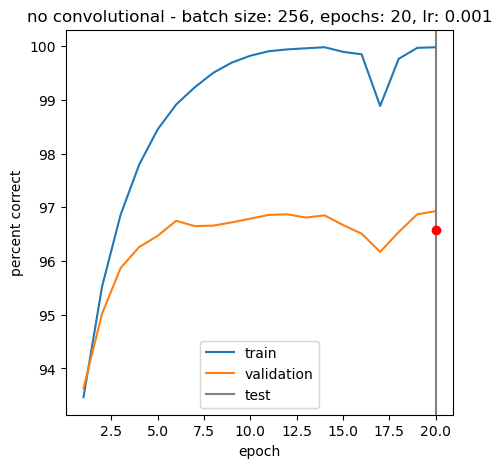

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 256, number of epochs 20, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 88.8 Val 90.0
adam Epoch 4 % Correct: Train 91.5 Val 92.3
adam Epoch 6 % Correct: Train 92.9 Val 93.1
adam Epoch 8 % Correct: Train 93.9 Val 93.8
adam Epoch 10 % Correct: Train 94.7 Val 94.3
adam Epoch 12 % Correct: Train 95.2 Val 94.7
adam Epoch 14 % Correct: Train 95.8 Val 95.2
adam Epoch 16 % Correct: Train 96.2 Val 95.4
adam Epoch 18 % Correct: Train 96.7 Val 95.7
adam Epoch 20 % Correct: Train 97.0 Val 95.9
no convolutional - batch size: 256, epochs: 20, lr: 0.0001: % correct: train 97.0 val 95.9 test 95.3


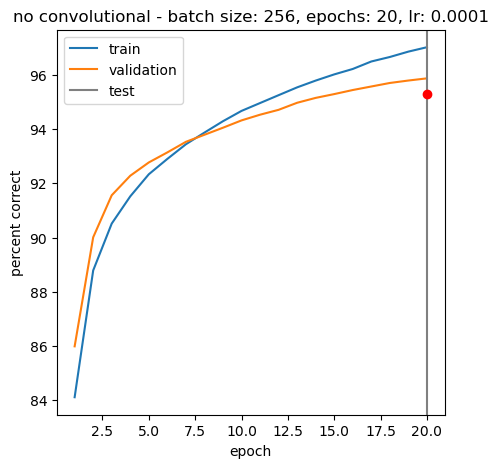

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 256, number of epochs 30, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 96.5 Val 95.1
adam Epoch 6 % Correct: Train 97.1 Val 95.3
adam Epoch 9 % Correct: Train 97.4 Val 95.6
adam Epoch 12 % Correct: Train 97.6 Val 95.1
adam Epoch 15 % Correct: Train 97.9 Val 95.7
adam Epoch 18 % Correct: Train 97.8 Val 95.2
adam Epoch 21 % Correct: Train 97.9 Val 95.5
adam Epoch 24 % Correct: Train 98.0 Val 95.5
adam Epoch 27 % Correct: Train 98.2 Val 95.7
adam Epoch 30 % Correct: Train 98.2 Val 95.5
no convolutional - batch size: 256, epochs: 30, lr: 0.01: % correct: train 98.2 val 95.9 test 95.3


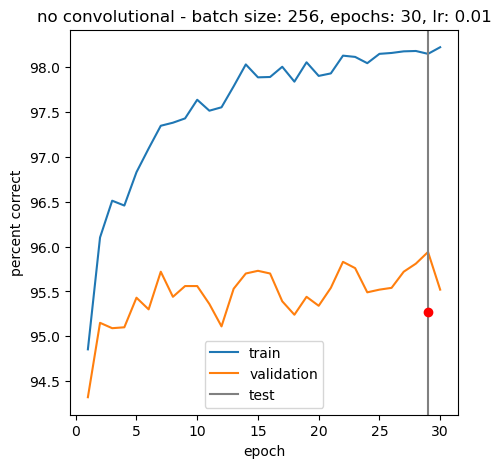

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 256, number of epochs 30, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 97.0 Val 95.8
adam Epoch 6 % Correct: Train 98.9 Val 96.6
adam Epoch 9 % Correct: Train 99.7 Val 96.7
adam Epoch 12 % Correct: Train 99.9 Val 96.7
adam Epoch 15 % Correct: Train 100.0 Val 96.7
adam Epoch 18 % Correct: Train 100.0 Val 96.8
adam Epoch 21 % Correct: Train 100.0 Val 96.9
adam Epoch 24 % Correct: Train 100.0 Val 96.8
adam Epoch 27 % Correct: Train 100.0 Val 96.8
adam Epoch 30 % Correct: Train 100.0 Val 96.8
no convolutional - batch size: 256, epochs: 30, lr: 0.001: % correct: train 100.0 val 96.9 test 96.7


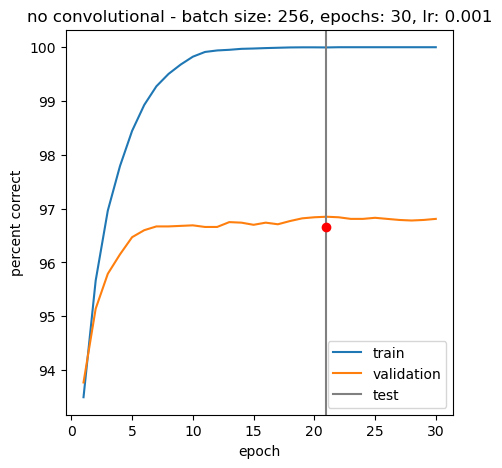

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 256, number of epochs 30, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 90.4 Val 91.2
adam Epoch 6 % Correct: Train 92.7 Val 93.0
adam Epoch 9 % Correct: Train 94.1 Val 93.9
adam Epoch 12 % Correct: Train 95.1 Val 94.6
adam Epoch 15 % Correct: Train 95.8 Val 95.1
adam Epoch 18 % Correct: Train 96.5 Val 95.5
adam Epoch 21 % Correct: Train 97.1 Val 95.9
adam Epoch 24 % Correct: Train 97.6 Val 96.0
adam Epoch 27 % Correct: Train 98.0 Val 96.2
adam Epoch 30 % Correct: Train 98.4 Val 96.4
no convolutional - batch size: 256, epochs: 30, lr: 0.0001: % correct: train 98.4 val 96.4 test 96.0


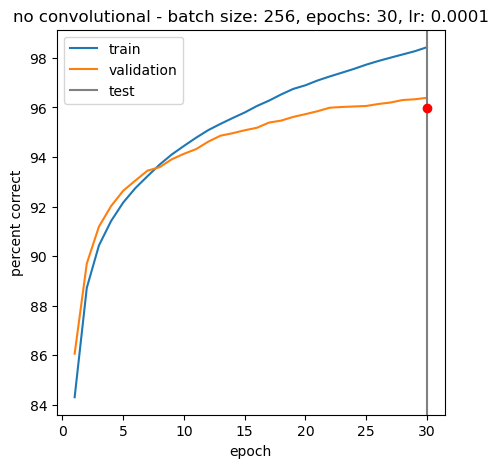

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 512, number of epochs 10, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 94.9 Val 94.4
adam Epoch 2 % Correct: Train 96.6 Val 95.0
adam Epoch 3 % Correct: Train 97.3 Val 95.6
adam Epoch 4 % Correct: Train 97.5 Val 95.5
adam Epoch 5 % Correct: Train 98.2 Val 95.9
adam Epoch 6 % Correct: Train 98.3 Val 96.0
adam Epoch 7 % Correct: Train 98.4 Val 95.7
adam Epoch 8 % Correct: Train 98.1 Val 95.5
adam Epoch 9 % Correct: Train 98.5 Val 95.7
adam Epoch 10 % Correct: Train 98.7 Val 95.9
no convolutional - batch size: 512, epochs: 10, lr: 0.01: % correct: train 98.3 val 96.0 test 95.6


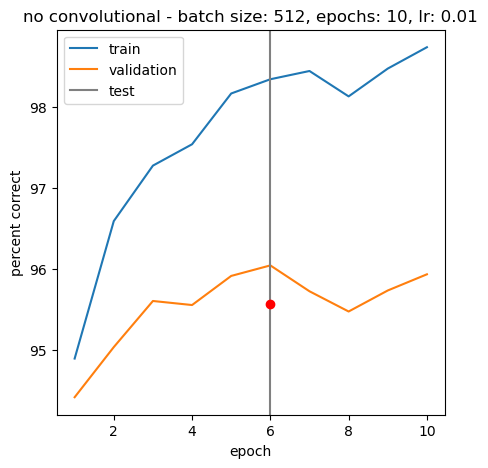

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 512, number of epochs 10, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 92.1 Val 92.9
adam Epoch 2 % Correct: Train 94.5 Val 94.6
adam Epoch 3 % Correct: Train 95.9 Val 95.4
adam Epoch 4 % Correct: Train 97.0 Val 95.9
adam Epoch 5 % Correct: Train 97.7 Val 96.3
adam Epoch 6 % Correct: Train 98.3 Val 96.4
adam Epoch 7 % Correct: Train 98.8 Val 96.5
adam Epoch 8 % Correct: Train 99.1 Val 96.6
adam Epoch 9 % Correct: Train 99.4 Val 96.6
adam Epoch 10 % Correct: Train 99.6 Val 96.6
no convolutional - batch size: 512, epochs: 10, lr: 0.001: % correct: train 99.4 val 96.6 test 96.4


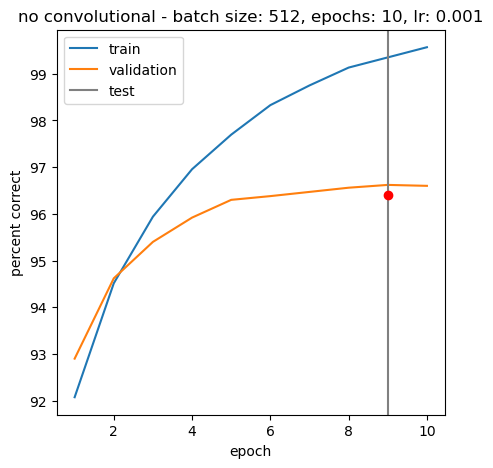

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 512, number of epochs 10, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 75.4 Val 77.5
adam Epoch 2 % Correct: Train 84.5 Val 85.8
adam Epoch 3 % Correct: Train 87.9 Val 89.0
adam Epoch 4 % Correct: Train 89.4 Val 90.3
adam Epoch 5 % Correct: Train 90.3 Val 91.2
adam Epoch 6 % Correct: Train 91.0 Val 91.7
adam Epoch 7 % Correct: Train 91.6 Val 92.2
adam Epoch 8 % Correct: Train 92.0 Val 92.6
adam Epoch 9 % Correct: Train 92.5 Val 93.0
adam Epoch 10 % Correct: Train 92.8 Val 93.2
no convolutional - batch size: 512, epochs: 10, lr: 0.0001: % correct: train 92.8 val 93.2 test 92.5


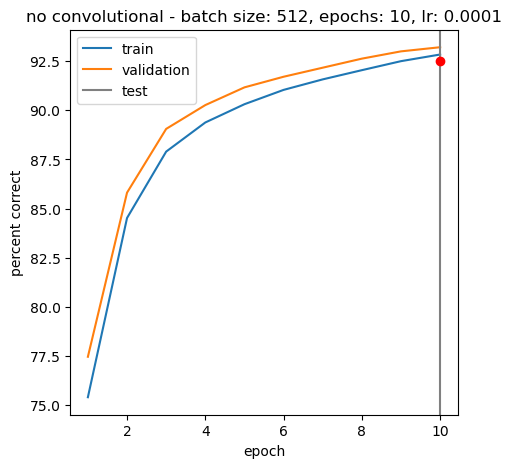

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 512, number of epochs 20, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 96.3 Val 95.0
adam Epoch 4 % Correct: Train 97.7 Val 95.5
adam Epoch 6 % Correct: Train 97.9 Val 95.7
adam Epoch 8 % Correct: Train 98.3 Val 95.7
adam Epoch 10 % Correct: Train 98.7 Val 96.1
adam Epoch 12 % Correct: Train 98.7 Val 95.9
adam Epoch 14 % Correct: Train 98.7 Val 95.7
adam Epoch 16 % Correct: Train 98.8 Val 96.0
adam Epoch 18 % Correct: Train 98.7 Val 95.8
adam Epoch 20 % Correct: Train 98.8 Val 96.0
no convolutional - batch size: 512, epochs: 20, lr: 0.01: % correct: train 98.8 val 96.2 test 95.7


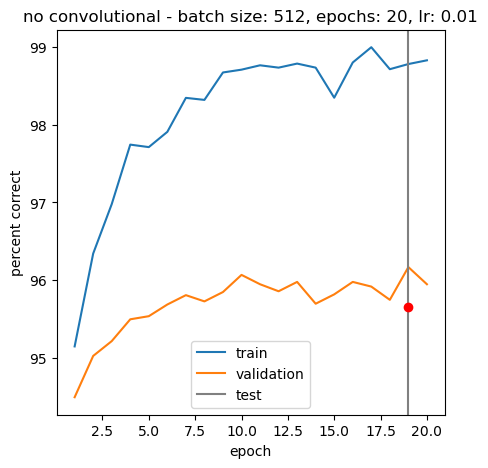

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 512, number of epochs 20, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 94.5 Val 94.4
adam Epoch 4 % Correct: Train 96.8 Val 95.7
adam Epoch 6 % Correct: Train 98.2 Val 96.3
adam Epoch 8 % Correct: Train 99.0 Val 96.6
adam Epoch 10 % Correct: Train 99.5 Val 96.6
adam Epoch 12 % Correct: Train 99.7 Val 96.7
adam Epoch 14 % Correct: Train 99.9 Val 96.8
adam Epoch 16 % Correct: Train 99.9 Val 96.8
adam Epoch 18 % Correct: Train 100.0 Val 96.8
adam Epoch 20 % Correct: Train 100.0 Val 96.9
no convolutional - batch size: 512, epochs: 20, lr: 0.001: % correct: train 100.0 val 96.9 test 96.6


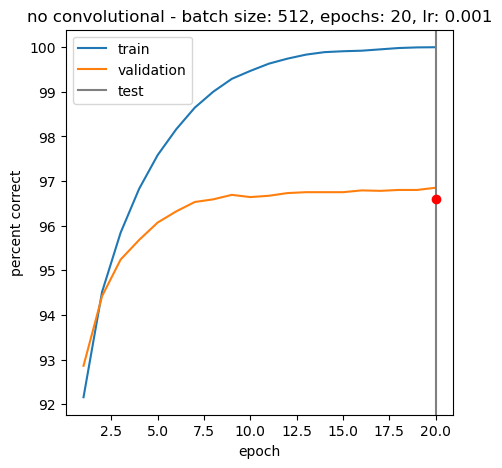

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 512, number of epochs 20, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 83.9 Val 86.0
adam Epoch 4 % Correct: Train 89.3 Val 90.3
adam Epoch 6 % Correct: Train 91.1 Val 91.9
adam Epoch 8 % Correct: Train 92.2 Val 92.5
adam Epoch 10 % Correct: Train 92.9 Val 93.1
adam Epoch 12 % Correct: Train 93.5 Val 93.7
adam Epoch 14 % Correct: Train 94.0 Val 94.0
adam Epoch 16 % Correct: Train 94.4 Val 94.3
adam Epoch 18 % Correct: Train 94.9 Val 94.6
adam Epoch 20 % Correct: Train 95.3 Val 94.8
no convolutional - batch size: 512, epochs: 20, lr: 0.0001: % correct: train 95.3 val 94.8 test 94.2


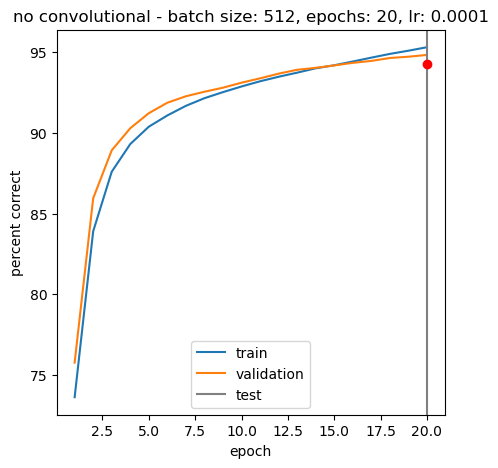

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 512, number of epochs 30, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 97.1 Val 95.3
adam Epoch 6 % Correct: Train 98.0 Val 95.9
adam Epoch 9 % Correct: Train 98.5 Val 95.8
adam Epoch 12 % Correct: Train 99.1 Val 96.1
adam Epoch 15 % Correct: Train 98.9 Val 96.4
adam Epoch 18 % Correct: Train 98.9 Val 96.0
adam Epoch 21 % Correct: Train 99.0 Val 95.8
adam Epoch 24 % Correct: Train 99.1 Val 96.2
adam Epoch 27 % Correct: Train 99.0 Val 96.0
adam Epoch 30 % Correct: Train 99.2 Val 95.8
no convolutional - batch size: 512, epochs: 30, lr: 0.01: % correct: train 98.9 val 96.4 test 95.8


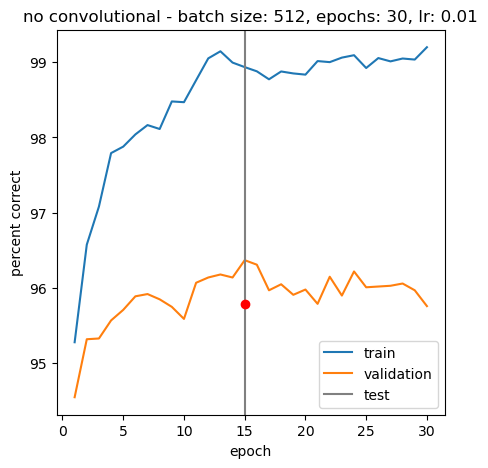

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 512, number of epochs 30, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 95.8 Val 95.2
adam Epoch 6 % Correct: Train 98.2 Val 96.2
adam Epoch 9 % Correct: Train 99.3 Val 96.4
adam Epoch 12 % Correct: Train 99.8 Val 96.5
adam Epoch 15 % Correct: Train 99.9 Val 96.4
adam Epoch 18 % Correct: Train 99.9 Val 96.5
adam Epoch 21 % Correct: Train 100.0 Val 96.6
adam Epoch 24 % Correct: Train 100.0 Val 96.6
adam Epoch 27 % Correct: Train 100.0 Val 96.5
adam Epoch 30 % Correct: Train 100.0 Val 96.6
no convolutional - batch size: 512, epochs: 30, lr: 0.001: % correct: train 100.0 val 96.6 test 96.7


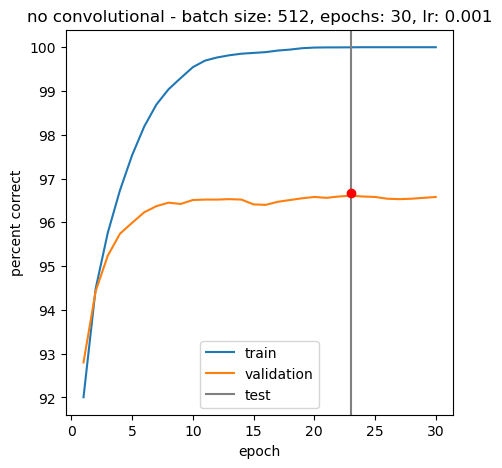

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 512, number of epochs 30, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 87.8 Val 88.9
adam Epoch 6 % Correct: Train 91.0 Val 91.7
adam Epoch 9 % Correct: Train 92.5 Val 92.7
adam Epoch 12 % Correct: Train 93.5 Val 93.4
adam Epoch 15 % Correct: Train 94.2 Val 94.0
adam Epoch 18 % Correct: Train 94.8 Val 94.5
adam Epoch 21 % Correct: Train 95.4 Val 94.9
adam Epoch 24 % Correct: Train 95.9 Val 95.1
adam Epoch 27 % Correct: Train 96.3 Val 95.4
adam Epoch 30 % Correct: Train 96.7 Val 95.6
no convolutional - batch size: 512, epochs: 30, lr: 0.0001: % correct: train 96.7 val 95.6 test 95.1


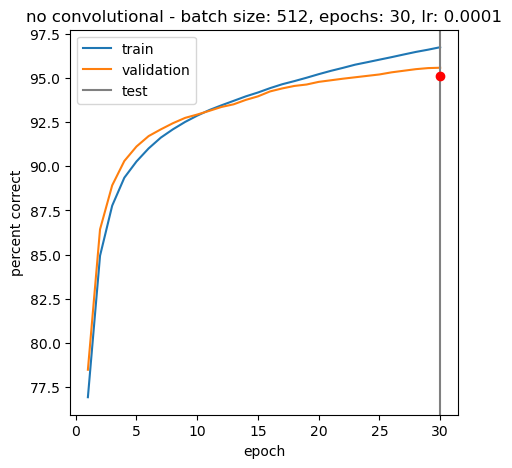

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 1024, number of epochs 10, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 94.8 Val 94.6
adam Epoch 2 % Correct: Train 96.8 Val 95.3
adam Epoch 3 % Correct: Train 97.7 Val 95.6
adam Epoch 4 % Correct: Train 98.3 Val 96.0
adam Epoch 5 % Correct: Train 98.5 Val 95.6
adam Epoch 6 % Correct: Train 98.8 Val 95.8
adam Epoch 7 % Correct: Train 98.6 Val 95.5
adam Epoch 8 % Correct: Train 98.8 Val 95.6
adam Epoch 9 % Correct: Train 99.1 Val 95.8
adam Epoch 10 % Correct: Train 99.3 Val 95.7
no convolutional - batch size: 1024, epochs: 10, lr: 0.01: % correct: train 98.3 val 96.0 test 95.3


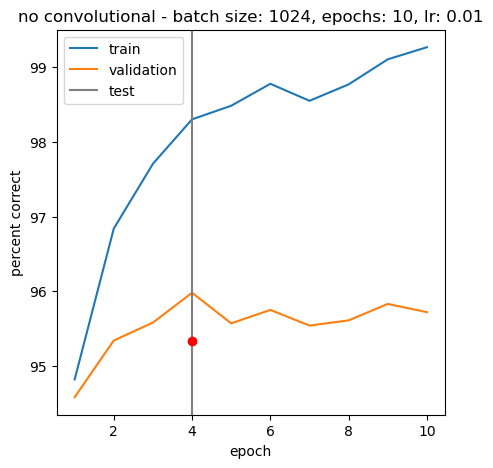

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 1024, number of epochs 10, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 89.4 Val 90.3
adam Epoch 2 % Correct: Train 92.7 Val 93.0
adam Epoch 3 % Correct: Train 94.2 Val 94.1
adam Epoch 4 % Correct: Train 95.2 Val 94.6
adam Epoch 5 % Correct: Train 96.1 Val 95.2
adam Epoch 6 % Correct: Train 96.8 Val 95.6
adam Epoch 7 % Correct: Train 97.3 Val 95.8
adam Epoch 8 % Correct: Train 97.8 Val 96.0
adam Epoch 9 % Correct: Train 98.2 Val 96.2
adam Epoch 10 % Correct: Train 98.5 Val 96.3
no convolutional - batch size: 1024, epochs: 10, lr: 0.001: % correct: train 98.5 val 96.3 test 96.1


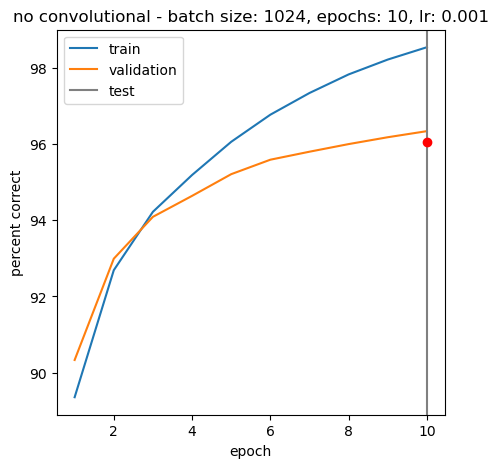

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 1024, number of epochs 10, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 70.9 Val 72.3
adam Epoch 2 % Correct: Train 77.6 Val 79.5
adam Epoch 3 % Correct: Train 82.3 Val 84.3
adam Epoch 4 % Correct: Train 85.3 Val 87.1
adam Epoch 5 % Correct: Train 87.2 Val 88.6
adam Epoch 6 % Correct: Train 88.4 Val 89.5
adam Epoch 7 % Correct: Train 89.2 Val 90.0
adam Epoch 8 % Correct: Train 89.9 Val 90.7
adam Epoch 9 % Correct: Train 90.5 Val 91.2
adam Epoch 10 % Correct: Train 90.8 Val 91.6
no convolutional - batch size: 1024, epochs: 10, lr: 0.0001: % correct: train 90.8 val 91.6 test 90.7


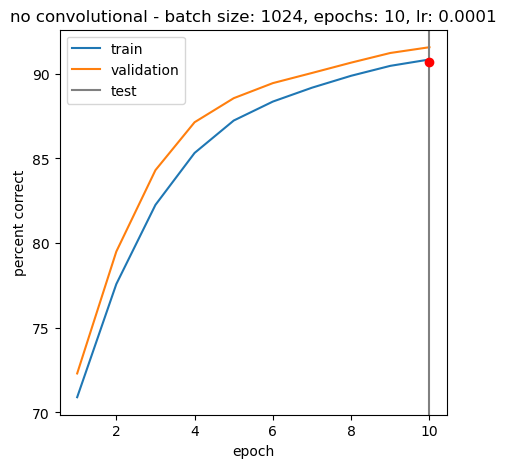

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 1024, number of epochs 20, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 96.8 Val 95.6
adam Epoch 4 % Correct: Train 98.3 Val 95.9
adam Epoch 6 % Correct: Train 98.3 Val 95.9
adam Epoch 8 % Correct: Train 98.8 Val 95.7
adam Epoch 10 % Correct: Train 99.2 Val 96.1
adam Epoch 12 % Correct: Train 99.5 Val 96.1
adam Epoch 14 % Correct: Train 99.5 Val 96.0
adam Epoch 16 % Correct: Train 99.5 Val 96.1
adam Epoch 18 % Correct: Train 99.6 Val 96.2
adam Epoch 20 % Correct: Train 99.5 Val 96.0
no convolutional - batch size: 1024, epochs: 20, lr: 0.01: % correct: train 99.4 val 96.3 test 95.6


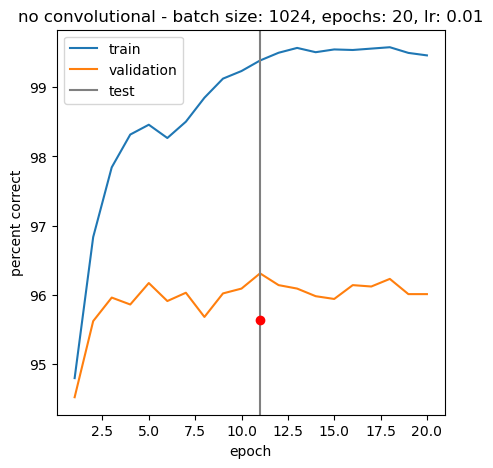

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 1024, number of epochs 20, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 92.8 Val 93.1
adam Epoch 4 % Correct: Train 95.3 Val 94.8
adam Epoch 6 % Correct: Train 96.9 Val 95.5
adam Epoch 8 % Correct: Train 97.9 Val 96.1
adam Epoch 10 % Correct: Train 98.6 Val 96.2
adam Epoch 12 % Correct: Train 99.2 Val 96.6
adam Epoch 14 % Correct: Train 99.5 Val 96.7
adam Epoch 16 % Correct: Train 99.7 Val 96.8
adam Epoch 18 % Correct: Train 99.9 Val 96.8
adam Epoch 20 % Correct: Train 99.9 Val 96.8
no convolutional - batch size: 1024, epochs: 20, lr: 0.001: % correct: train 99.7 val 96.8 test 96.6


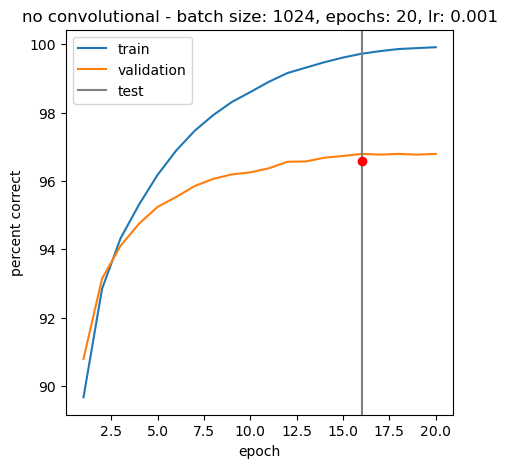

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 1024, number of epochs 20, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 75.5 Val 78.0
adam Epoch 4 % Correct: Train 84.6 Val 86.6
adam Epoch 6 % Correct: Train 88.0 Val 89.3
adam Epoch 8 % Correct: Train 89.7 Val 90.7
adam Epoch 10 % Correct: Train 90.8 Val 91.4
adam Epoch 12 % Correct: Train 91.5 Val 92.1
adam Epoch 14 % Correct: Train 92.1 Val 92.6
adam Epoch 16 % Correct: Train 92.5 Val 92.8
adam Epoch 18 % Correct: Train 93.0 Val 93.1
adam Epoch 20 % Correct: Train 93.3 Val 93.4
no convolutional - batch size: 1024, epochs: 20, lr: 0.0001: % correct: train 93.3 val 93.4 test 92.9


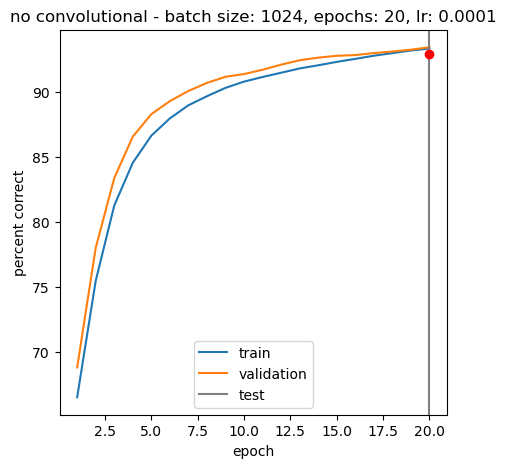

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 1024, number of epochs 30, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 97.6 Val 95.4
adam Epoch 6 % Correct: Train 98.7 Val 95.9
adam Epoch 9 % Correct: Train 99.1 Val 95.9
adam Epoch 12 % Correct: Train 99.2 Val 96.1
adam Epoch 15 % Correct: Train 99.4 Val 95.9
adam Epoch 18 % Correct: Train 99.6 Val 96.1
adam Epoch 21 % Correct: Train 99.4 Val 96.0
adam Epoch 24 % Correct: Train 99.6 Val 96.1
adam Epoch 27 % Correct: Train 99.6 Val 95.8
adam Epoch 30 % Correct: Train 99.5 Val 96.0
no convolutional - batch size: 1024, epochs: 30, lr: 0.01: % correct: train 99.5 val 96.2 test 95.7


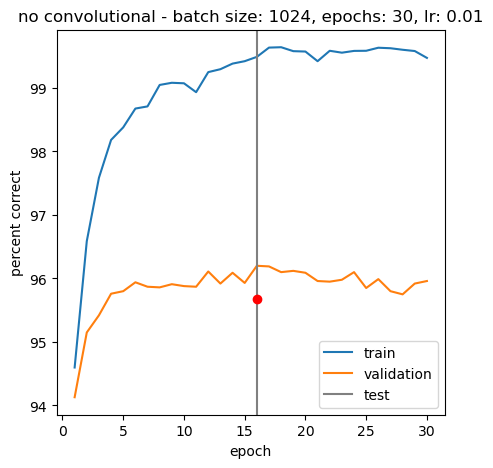

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 1024, number of epochs 30, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 94.2 Val 94.2
adam Epoch 6 % Correct: Train 96.8 Val 95.6
adam Epoch 9 % Correct: Train 98.3 Val 96.3
adam Epoch 12 % Correct: Train 99.2 Val 96.6
adam Epoch 15 % Correct: Train 99.6 Val 96.7
adam Epoch 18 % Correct: Train 99.9 Val 96.7
adam Epoch 21 % Correct: Train 100.0 Val 96.8
adam Epoch 24 % Correct: Train 100.0 Val 96.9
adam Epoch 27 % Correct: Train 100.0 Val 96.9
adam Epoch 30 % Correct: Train 100.0 Val 97.0
no convolutional - batch size: 1024, epochs: 30, lr: 0.001: % correct: train 100.0 val 97.0 test 96.3


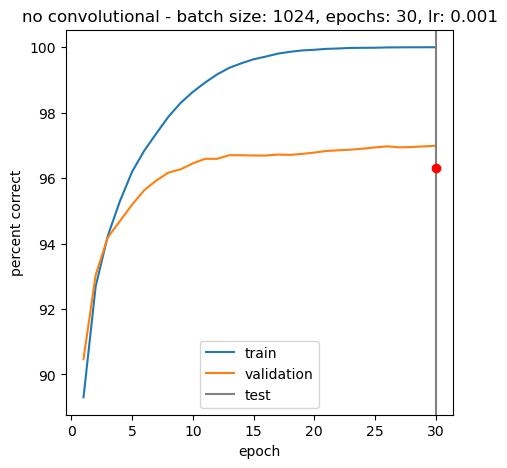

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutional with batch size 1024, number of epochs 30, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 82.3 Val 84.4
adam Epoch 6 % Correct: Train 88.2 Val 89.2
adam Epoch 9 % Correct: Train 90.3 Val 91.0
adam Epoch 12 % Correct: Train 91.5 Val 92.0
adam Epoch 15 % Correct: Train 92.3 Val 92.6
adam Epoch 18 % Correct: Train 92.9 Val 93.1
adam Epoch 21 % Correct: Train 93.5 Val 93.4
adam Epoch 24 % Correct: Train 93.9 Val 93.9
adam Epoch 27 % Correct: Train 94.4 Val 94.2
adam Epoch 30 % Correct: Train 94.8 Val 94.5
no convolutional - batch size: 1024, epochs: 30, lr: 0.0001: % correct: train 94.8 val 94.5 test 94.0


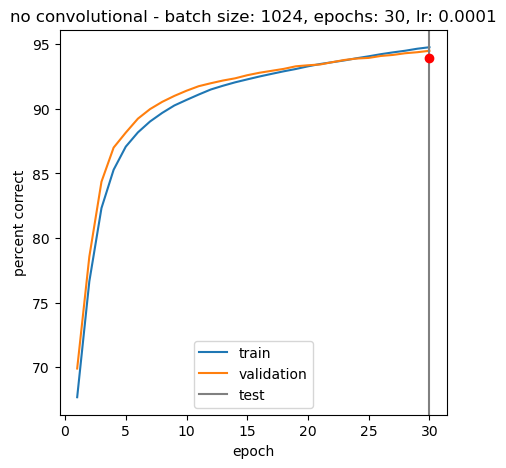

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 256, number of epochs 10, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 90.9 Val 91.0
adam Epoch 2 % Correct: Train 91.2 Val 91.0
adam Epoch 3 % Correct: Train 91.6 Val 91.3
adam Epoch 4 % Correct: Train 91.7 Val 91.3
adam Epoch 5 % Correct: Train 91.9 Val 91.3
adam Epoch 6 % Correct: Train 91.8 Val 91.1
adam Epoch 7 % Correct: Train 91.8 Val 91.0
adam Epoch 8 % Correct: Train 91.9 Val 91.0
adam Epoch 9 % Correct: Train 91.9 Val 90.9
adam Epoch 10 % Correct: Train 91.9 Val 90.8
no convolutionl and no fully connected - batch size: 256, epochs: 10, lr: 0.01: % correct: train 91.9 val 91.3 test 91.0


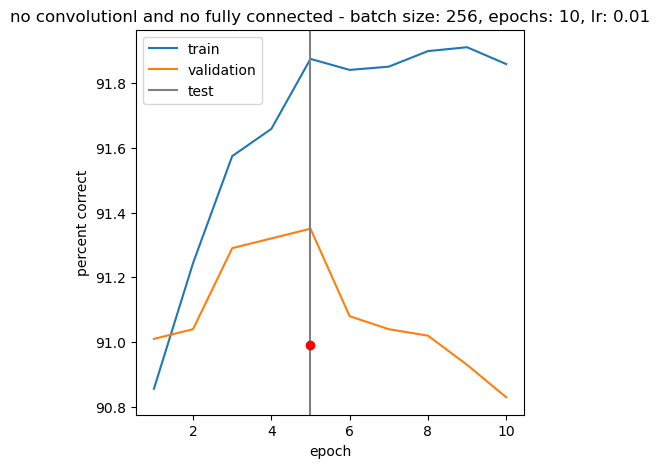

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 256, number of epochs 10, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 90.1 Val 90.9
adam Epoch 2 % Correct: Train 91.4 Val 91.8
adam Epoch 3 % Correct: Train 91.9 Val 92.2
adam Epoch 4 % Correct: Train 92.2 Val 92.3
adam Epoch 5 % Correct: Train 92.4 Val 92.5
adam Epoch 6 % Correct: Train 92.6 Val 92.6
adam Epoch 7 % Correct: Train 92.8 Val 92.6
adam Epoch 8 % Correct: Train 92.9 Val 92.6
adam Epoch 9 % Correct: Train 93.0 Val 92.7
adam Epoch 10 % Correct: Train 93.1 Val 92.7
no convolutionl and no fully connected - batch size: 256, epochs: 10, lr: 0.001: % correct: train 93.1 val 92.7 test 92.2


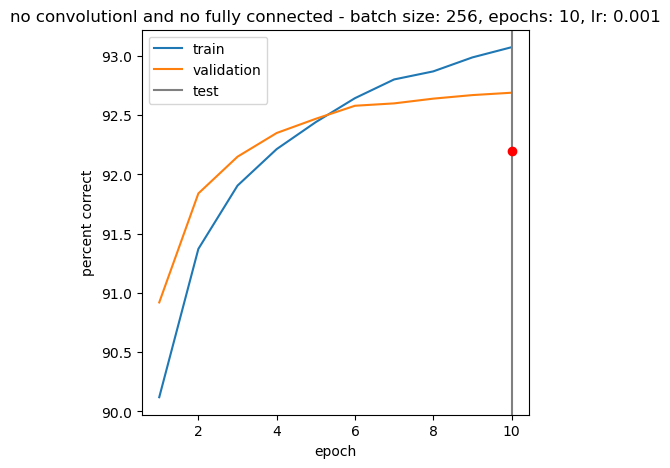

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 256, number of epochs 10, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 76.3 Val 78.9
adam Epoch 2 % Correct: Train 83.6 Val 85.6
adam Epoch 3 % Correct: Train 86.1 Val 87.7
adam Epoch 4 % Correct: Train 87.5 Val 88.9
adam Epoch 5 % Correct: Train 88.4 Val 89.6
adam Epoch 6 % Correct: Train 88.9 Val 90.0
adam Epoch 7 % Correct: Train 89.4 Val 90.5
adam Epoch 8 % Correct: Train 89.8 Val 90.8
adam Epoch 9 % Correct: Train 90.1 Val 91.1
adam Epoch 10 % Correct: Train 90.4 Val 91.3
no convolutionl and no fully connected - batch size: 256, epochs: 10, lr: 0.0001: % correct: train 90.4 val 91.3 test 90.5


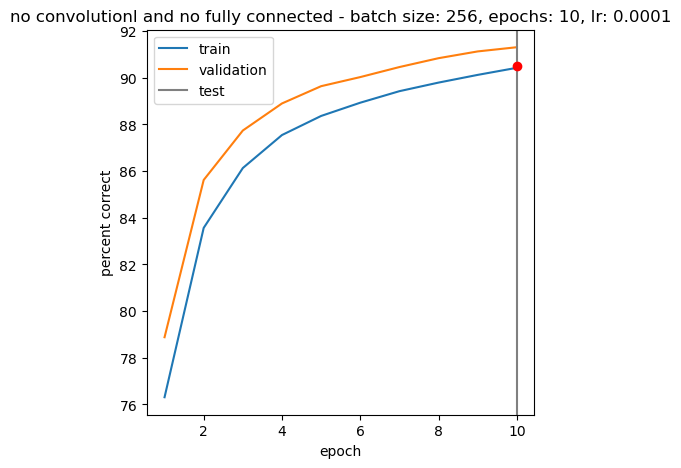

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 256, number of epochs 20, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 91.3 Val 91.3
adam Epoch 4 % Correct: Train 91.7 Val 91.2
adam Epoch 6 % Correct: Train 91.9 Val 91.1
adam Epoch 8 % Correct: Train 91.9 Val 91.1
adam Epoch 10 % Correct: Train 91.8 Val 91.0
adam Epoch 12 % Correct: Train 91.8 Val 91.0
adam Epoch 14 % Correct: Train 91.9 Val 90.9
adam Epoch 16 % Correct: Train 92.0 Val 90.9
adam Epoch 18 % Correct: Train 92.0 Val 90.8
adam Epoch 20 % Correct: Train 92.1 Val 90.9
no convolutionl and no fully connected - batch size: 256, epochs: 20, lr: 0.01: % correct: train 91.3 val 91.3 test 90.7


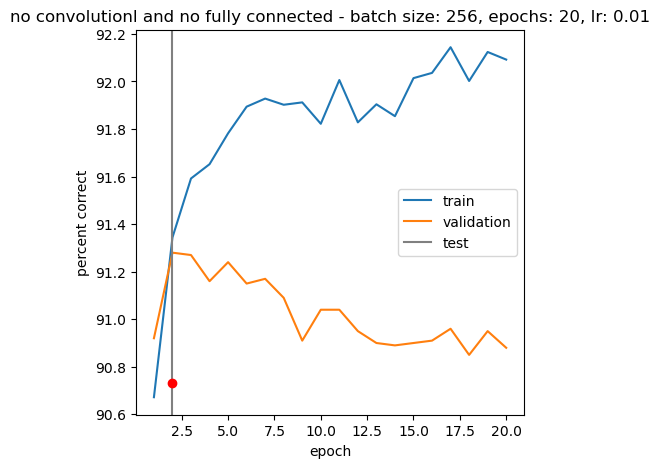

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 256, number of epochs 20, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 91.4 Val 91.7
adam Epoch 4 % Correct: Train 92.1 Val 92.4
adam Epoch 6 % Correct: Train 92.6 Val 92.6
adam Epoch 8 % Correct: Train 92.8 Val 92.7
adam Epoch 10 % Correct: Train 93.1 Val 92.7
adam Epoch 12 % Correct: Train 93.2 Val 92.7
adam Epoch 14 % Correct: Train 93.3 Val 92.7
adam Epoch 16 % Correct: Train 93.4 Val 92.7
adam Epoch 18 % Correct: Train 93.4 Val 92.7
adam Epoch 20 % Correct: Train 93.5 Val 92.8
no convolutionl and no fully connected - batch size: 256, epochs: 20, lr: 0.001: % correct: train 93.4 val 92.8 test 92.3


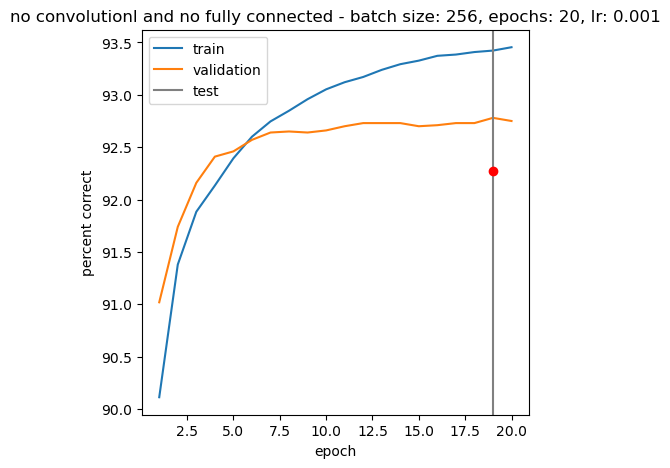

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 256, number of epochs 20, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 83.4 Val 85.4
adam Epoch 4 % Correct: Train 87.3 Val 88.8
adam Epoch 6 % Correct: Train 88.9 Val 90.1
adam Epoch 8 % Correct: Train 89.8 Val 91.0
adam Epoch 10 % Correct: Train 90.4 Val 91.3
adam Epoch 12 % Correct: Train 90.8 Val 91.5
adam Epoch 14 % Correct: Train 91.1 Val 91.8
adam Epoch 16 % Correct: Train 91.3 Val 91.9
adam Epoch 18 % Correct: Train 91.6 Val 92.1
adam Epoch 20 % Correct: Train 91.7 Val 92.2
no convolutionl and no fully connected - batch size: 256, epochs: 20, lr: 0.0001: % correct: train 91.7 val 92.2 test 91.8


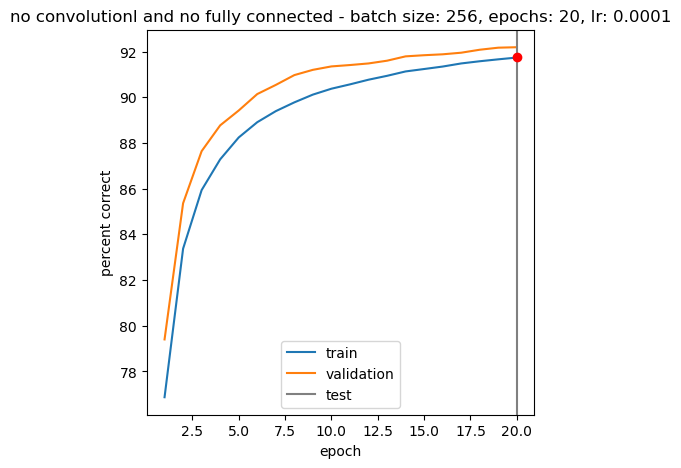

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 256, number of epochs 30, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 91.5 Val 91.4
adam Epoch 6 % Correct: Train 91.8 Val 91.1
adam Epoch 9 % Correct: Train 91.9 Val 91.0
adam Epoch 12 % Correct: Train 92.0 Val 90.9
adam Epoch 15 % Correct: Train 91.9 Val 90.8
adam Epoch 18 % Correct: Train 92.0 Val 90.9
adam Epoch 21 % Correct: Train 92.1 Val 91.0
adam Epoch 24 % Correct: Train 92.0 Val 90.7
adam Epoch 27 % Correct: Train 92.2 Val 90.9
adam Epoch 30 % Correct: Train 92.1 Val 90.7
no convolutionl and no fully connected - batch size: 256, epochs: 30, lr: 0.01: % correct: train 91.5 val 91.4 test 90.7


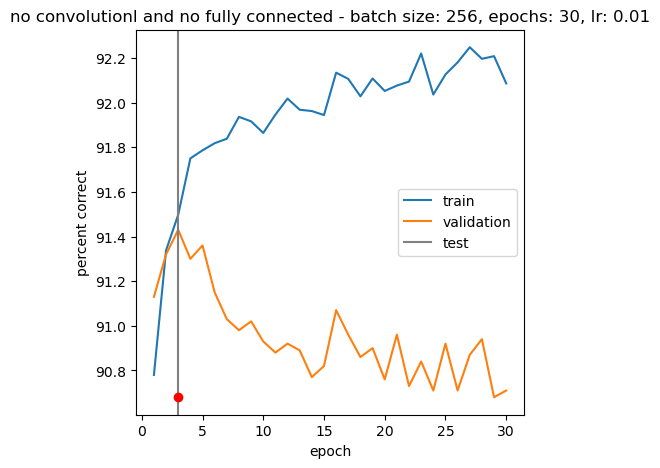

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 256, number of epochs 30, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 91.9 Val 92.1
adam Epoch 6 % Correct: Train 92.6 Val 92.5
adam Epoch 9 % Correct: Train 93.0 Val 92.6
adam Epoch 12 % Correct: Train 93.2 Val 92.7
adam Epoch 15 % Correct: Train 93.3 Val 92.7
adam Epoch 18 % Correct: Train 93.4 Val 92.7
adam Epoch 21 % Correct: Train 93.5 Val 92.7
adam Epoch 24 % Correct: Train 93.5 Val 92.8
adam Epoch 27 % Correct: Train 93.6 Val 92.7
adam Epoch 30 % Correct: Train 93.6 Val 92.7
no convolutionl and no fully connected - batch size: 256, epochs: 30, lr: 0.001: % correct: train 93.6 val 92.8 test 92.2


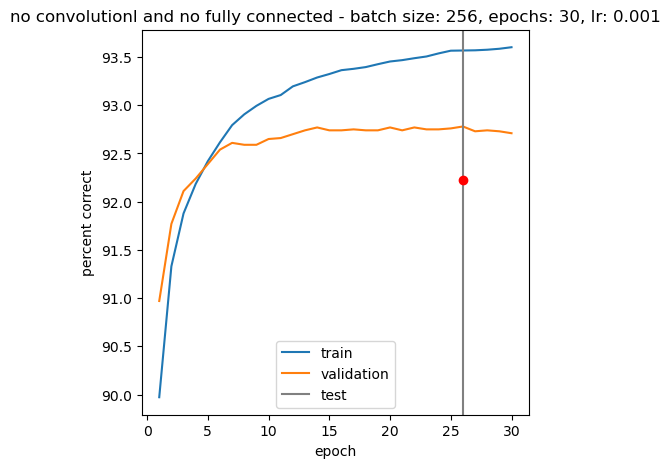

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 256, number of epochs 30, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 86.0 Val 87.4
adam Epoch 6 % Correct: Train 88.8 Val 90.0
adam Epoch 9 % Correct: Train 90.1 Val 90.9
adam Epoch 12 % Correct: Train 90.7 Val 91.5
adam Epoch 15 % Correct: Train 91.2 Val 91.8
adam Epoch 18 % Correct: Train 91.5 Val 92.0
adam Epoch 21 % Correct: Train 91.8 Val 92.1
adam Epoch 24 % Correct: Train 92.0 Val 92.2
adam Epoch 27 % Correct: Train 92.1 Val 92.3
adam Epoch 30 % Correct: Train 92.3 Val 92.4
no convolutionl and no fully connected - batch size: 256, epochs: 30, lr: 0.0001: % correct: train 92.2 val 92.4 test 92.1


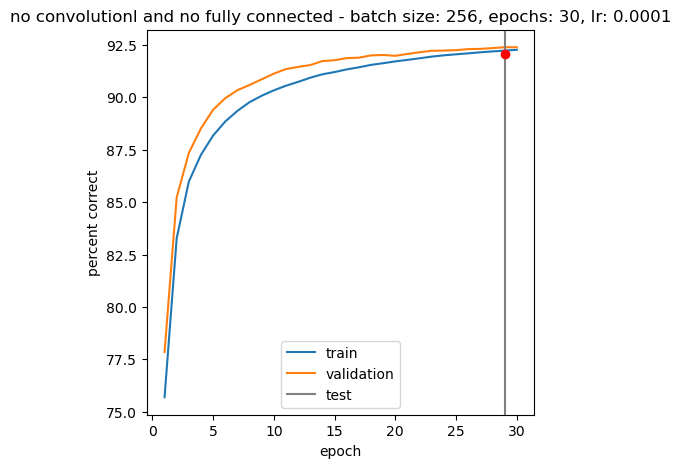

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 512, number of epochs 10, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 91.2 Val 91.5
adam Epoch 2 % Correct: Train 91.6 Val 91.8
adam Epoch 3 % Correct: Train 91.7 Val 91.6
adam Epoch 4 % Correct: Train 91.8 Val 91.7
adam Epoch 5 % Correct: Train 91.9 Val 91.8
adam Epoch 6 % Correct: Train 91.9 Val 91.5
adam Epoch 7 % Correct: Train 92.0 Val 91.5
adam Epoch 8 % Correct: Train 92.0 Val 91.5
adam Epoch 9 % Correct: Train 92.1 Val 91.7
adam Epoch 10 % Correct: Train 92.1 Val 91.4
no convolutionl and no fully connected - batch size: 512, epochs: 10, lr: 0.01: % correct: train 91.6 val 91.8 test 90.8


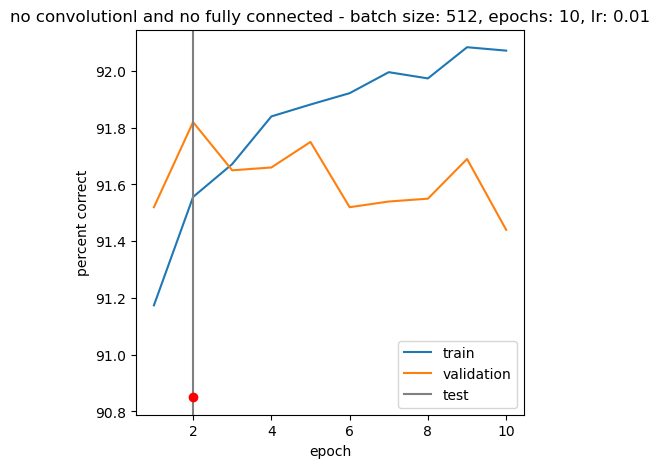

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 512, number of epochs 10, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 88.5 Val 89.8
adam Epoch 2 % Correct: Train 90.4 Val 91.3
adam Epoch 3 % Correct: Train 91.2 Val 91.7
adam Epoch 4 % Correct: Train 91.7 Val 92.0
adam Epoch 5 % Correct: Train 92.0 Val 92.2
adam Epoch 6 % Correct: Train 92.2 Val 92.3
adam Epoch 7 % Correct: Train 92.4 Val 92.5
adam Epoch 8 % Correct: Train 92.6 Val 92.5
adam Epoch 9 % Correct: Train 92.7 Val 92.6
adam Epoch 10 % Correct: Train 92.8 Val 92.7
no convolutionl and no fully connected - batch size: 512, epochs: 10, lr: 0.001: % correct: train 92.8 val 92.7 test 92.2


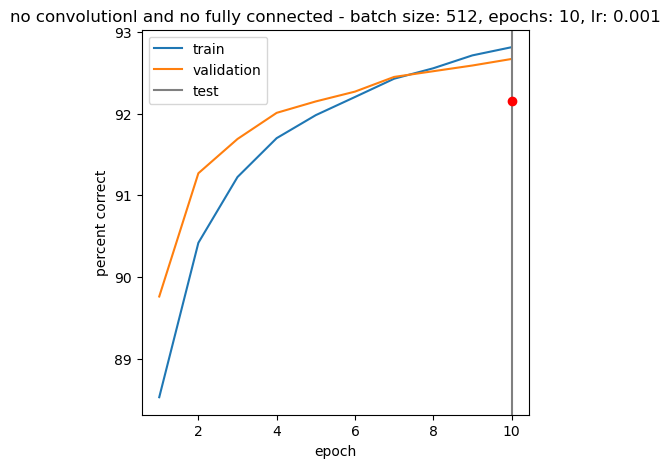

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 512, number of epochs 10, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 68.4 Val 70.4
adam Epoch 2 % Correct: Train 77.8 Val 79.9
adam Epoch 3 % Correct: Train 82.0 Val 83.8
adam Epoch 4 % Correct: Train 84.3 Val 85.9
adam Epoch 5 % Correct: Train 85.7 Val 87.1
adam Epoch 6 % Correct: Train 86.6 Val 88.0
adam Epoch 7 % Correct: Train 87.3 Val 88.8
adam Epoch 8 % Correct: Train 87.8 Val 89.2
adam Epoch 9 % Correct: Train 88.3 Val 89.6
adam Epoch 10 % Correct: Train 88.6 Val 89.9
no convolutionl and no fully connected - batch size: 512, epochs: 10, lr: 0.0001: % correct: train 88.6 val 89.9 test 89.1


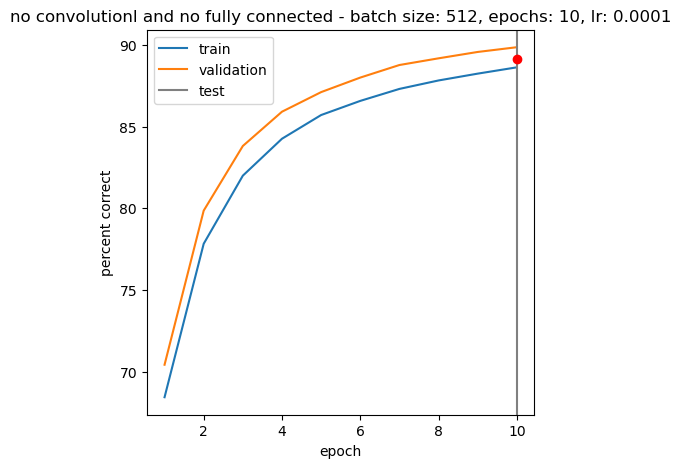

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 512, number of epochs 20, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 91.5 Val 91.7
adam Epoch 4 % Correct: Train 91.9 Val 91.8
adam Epoch 6 % Correct: Train 91.9 Val 91.6
adam Epoch 8 % Correct: Train 92.0 Val 91.6
adam Epoch 10 % Correct: Train 92.1 Val 91.6
adam Epoch 12 % Correct: Train 92.1 Val 91.4
adam Epoch 14 % Correct: Train 92.2 Val 91.4
adam Epoch 16 % Correct: Train 92.2 Val 91.2
adam Epoch 18 % Correct: Train 92.3 Val 91.3
adam Epoch 20 % Correct: Train 92.4 Val 91.2
no convolutionl and no fully connected - batch size: 512, epochs: 20, lr: 0.01: % correct: train 91.9 val 91.8 test 90.9


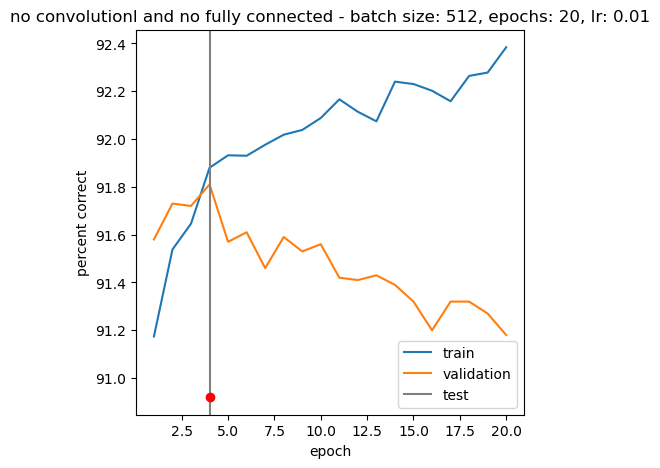

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 512, number of epochs 20, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 90.5 Val 91.1
adam Epoch 4 % Correct: Train 91.7 Val 91.9
adam Epoch 6 % Correct: Train 92.2 Val 92.2
adam Epoch 8 % Correct: Train 92.6 Val 92.5
adam Epoch 10 % Correct: Train 92.8 Val 92.6
adam Epoch 12 % Correct: Train 93.0 Val 92.6
adam Epoch 14 % Correct: Train 93.1 Val 92.8
adam Epoch 16 % Correct: Train 93.2 Val 92.7
adam Epoch 18 % Correct: Train 93.3 Val 92.7
adam Epoch 20 % Correct: Train 93.4 Val 92.8
no convolutionl and no fully connected - batch size: 512, epochs: 20, lr: 0.001: % correct: train 93.1 val 92.8 test 92.3


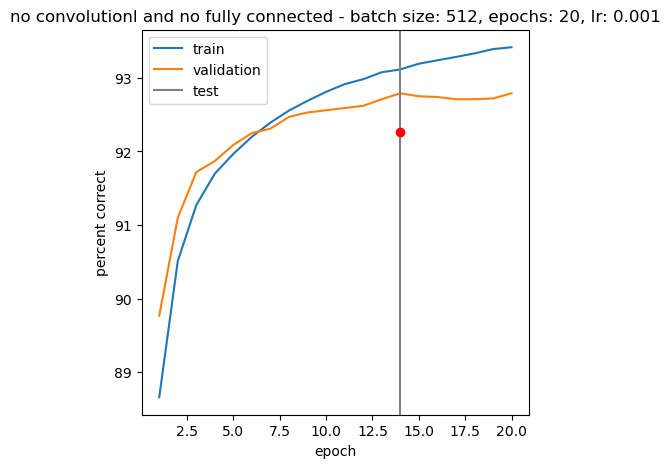

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 512, number of epochs 20, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 76.7 Val 79.1
adam Epoch 4 % Correct: Train 83.9 Val 85.7
adam Epoch 6 % Correct: Train 86.5 Val 87.9
adam Epoch 8 % Correct: Train 87.9 Val 89.1
adam Epoch 10 % Correct: Train 88.7 Val 90.0
adam Epoch 12 % Correct: Train 89.2 Val 90.4
adam Epoch 14 % Correct: Train 89.7 Val 90.7
adam Epoch 16 % Correct: Train 90.0 Val 91.0
adam Epoch 18 % Correct: Train 90.4 Val 91.2
adam Epoch 20 % Correct: Train 90.6 Val 91.4
no convolutionl and no fully connected - batch size: 512, epochs: 20, lr: 0.0001: % correct: train 90.6 val 91.4 test 90.7


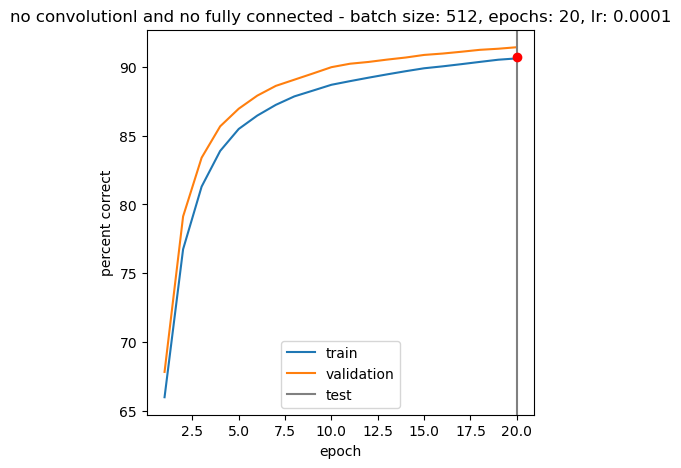

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 512, number of epochs 30, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 91.7 Val 91.8
adam Epoch 6 % Correct: Train 91.9 Val 91.6
adam Epoch 9 % Correct: Train 92.1 Val 91.5
adam Epoch 12 % Correct: Train 92.2 Val 91.4
adam Epoch 15 % Correct: Train 92.2 Val 91.3
adam Epoch 18 % Correct: Train 92.2 Val 91.3
adam Epoch 21 % Correct: Train 92.3 Val 91.2
adam Epoch 24 % Correct: Train 92.4 Val 91.1
adam Epoch 27 % Correct: Train 92.3 Val 91.0
adam Epoch 30 % Correct: Train 92.3 Val 91.1
no convolutionl and no fully connected - batch size: 512, epochs: 30, lr: 0.01: % correct: train 91.7 val 91.8 test 90.8


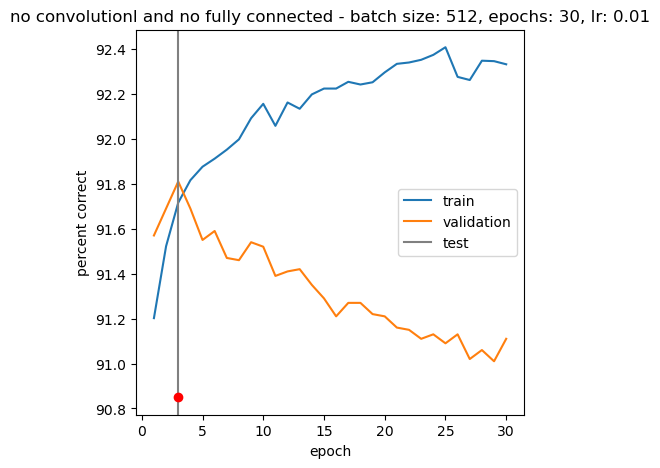

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 512, number of epochs 30, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 91.2 Val 91.7
adam Epoch 6 % Correct: Train 92.2 Val 92.3
adam Epoch 9 % Correct: Train 92.7 Val 92.6
adam Epoch 12 % Correct: Train 93.0 Val 92.8
adam Epoch 15 % Correct: Train 93.2 Val 92.8
adam Epoch 18 % Correct: Train 93.3 Val 92.8
adam Epoch 21 % Correct: Train 93.4 Val 92.8
adam Epoch 24 % Correct: Train 93.5 Val 92.8
adam Epoch 27 % Correct: Train 93.6 Val 92.8
adam Epoch 30 % Correct: Train 93.6 Val 92.8
no convolutionl and no fully connected - batch size: 512, epochs: 30, lr: 0.001: % correct: train 93.6 val 92.8 test 92.4


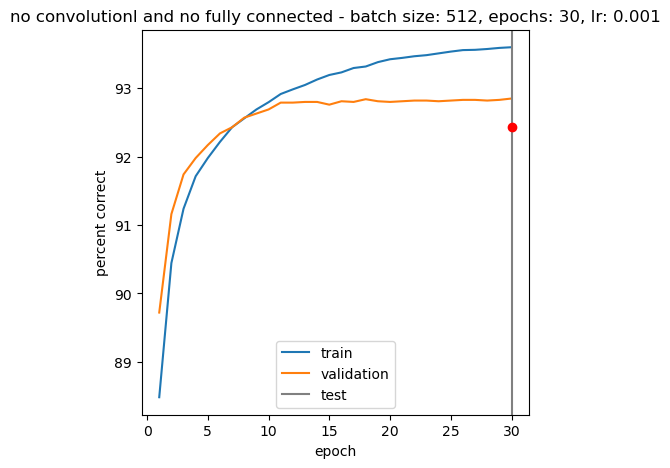

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 512, number of epochs 30, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 81.6 Val 83.5
adam Epoch 6 % Correct: Train 86.4 Val 87.8
adam Epoch 9 % Correct: Train 88.2 Val 89.4
adam Epoch 12 % Correct: Train 89.2 Val 90.1
adam Epoch 15 % Correct: Train 89.8 Val 90.7
adam Epoch 18 % Correct: Train 90.3 Val 91.1
adam Epoch 21 % Correct: Train 90.7 Val 91.4
adam Epoch 24 % Correct: Train 91.0 Val 91.6
adam Epoch 27 % Correct: Train 91.3 Val 91.8
adam Epoch 30 % Correct: Train 91.4 Val 91.9
no convolutionl and no fully connected - batch size: 512, epochs: 30, lr: 0.0001: % correct: train 91.4 val 91.9 test 91.6


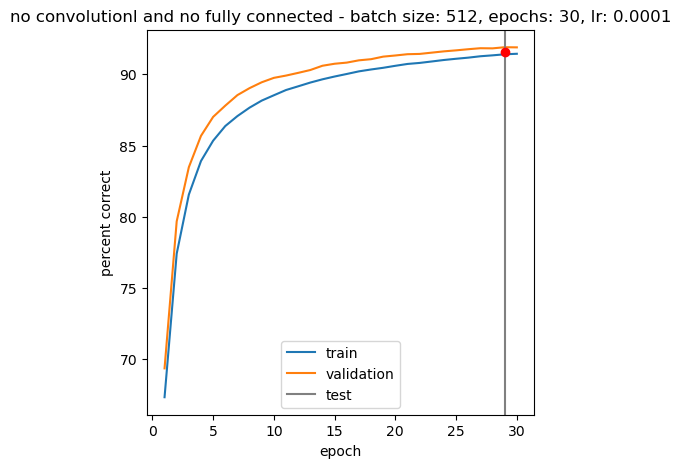

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 1024, number of epochs 10, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 91.2 Val 91.8
adam Epoch 2 % Correct: Train 92.0 Val 92.1
adam Epoch 3 % Correct: Train 92.3 Val 92.3
adam Epoch 4 % Correct: Train 92.5 Val 92.3
adam Epoch 5 % Correct: Train 92.6 Val 92.3
adam Epoch 6 % Correct: Train 92.7 Val 92.3
adam Epoch 7 % Correct: Train 92.8 Val 92.3
adam Epoch 8 % Correct: Train 92.9 Val 92.2
adam Epoch 9 % Correct: Train 93.0 Val 92.2
adam Epoch 10 % Correct: Train 92.9 Val 92.2
no convolutionl and no fully connected - batch size: 1024, epochs: 10, lr: 0.01: % correct: train 92.7 val 92.3 test 91.5


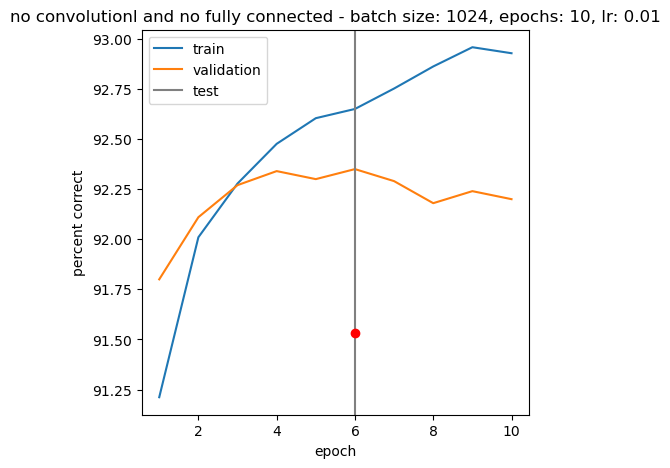

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 1024, number of epochs 10, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 86.2 Val 87.8
adam Epoch 2 % Correct: Train 89.1 Val 90.2
adam Epoch 3 % Correct: Train 90.2 Val 91.0
adam Epoch 4 % Correct: Train 90.8 Val 91.4
adam Epoch 5 % Correct: Train 91.3 Val 91.7
adam Epoch 6 % Correct: Train 91.6 Val 92.0
adam Epoch 7 % Correct: Train 91.8 Val 92.2
adam Epoch 8 % Correct: Train 92.0 Val 92.3
adam Epoch 9 % Correct: Train 92.1 Val 92.3
adam Epoch 10 % Correct: Train 92.2 Val 92.4
no convolutionl and no fully connected - batch size: 1024, epochs: 10, lr: 0.001: % correct: train 92.2 val 92.4 test 91.8


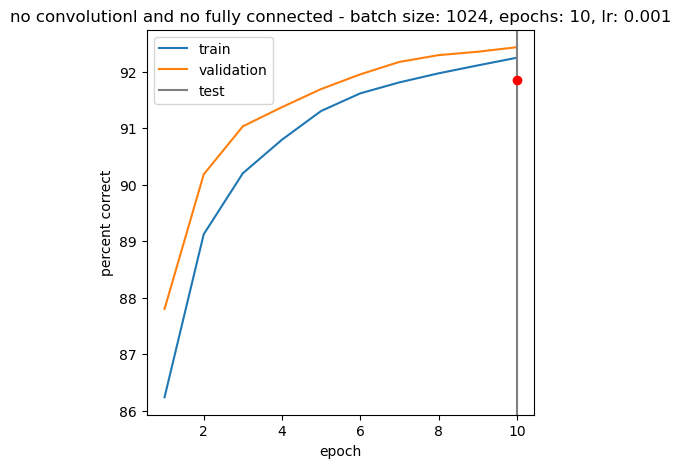

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 1024, number of epochs 10, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 1 % Correct: Train 47.0 Val 47.2
adam Epoch 2 % Correct: Train 66.3 Val 67.4
adam Epoch 3 % Correct: Train 74.0 Val 76.2
adam Epoch 4 % Correct: Train 78.1 Val 80.2
adam Epoch 5 % Correct: Train 80.7 Val 82.5
adam Epoch 6 % Correct: Train 82.4 Val 84.1
adam Epoch 7 % Correct: Train 83.6 Val 85.4
adam Epoch 8 % Correct: Train 84.5 Val 86.2
adam Epoch 9 % Correct: Train 85.3 Val 86.8
adam Epoch 10 % Correct: Train 85.9 Val 87.4
no convolutionl and no fully connected - batch size: 1024, epochs: 10, lr: 0.0001: % correct: train 85.9 val 87.4 test 86.9


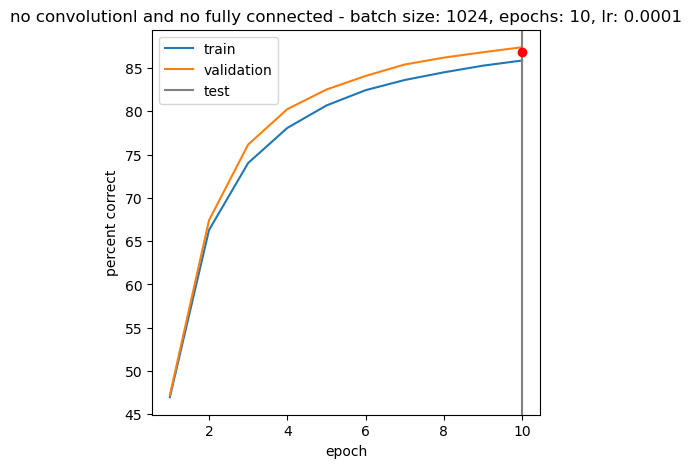

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 1024, number of epochs 20, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 92.0 Val 92.2
adam Epoch 4 % Correct: Train 92.4 Val 92.3
adam Epoch 6 % Correct: Train 92.7 Val 92.3
adam Epoch 8 % Correct: Train 92.8 Val 92.3
adam Epoch 10 % Correct: Train 92.9 Val 92.2
adam Epoch 12 % Correct: Train 93.0 Val 92.2
adam Epoch 14 % Correct: Train 93.0 Val 92.2
adam Epoch 16 % Correct: Train 93.1 Val 92.2
adam Epoch 18 % Correct: Train 93.1 Val 92.1
adam Epoch 20 % Correct: Train 93.1 Val 92.2
no convolutionl and no fully connected - batch size: 1024, epochs: 20, lr: 0.01: % correct: train 92.6 val 92.4 test 91.6


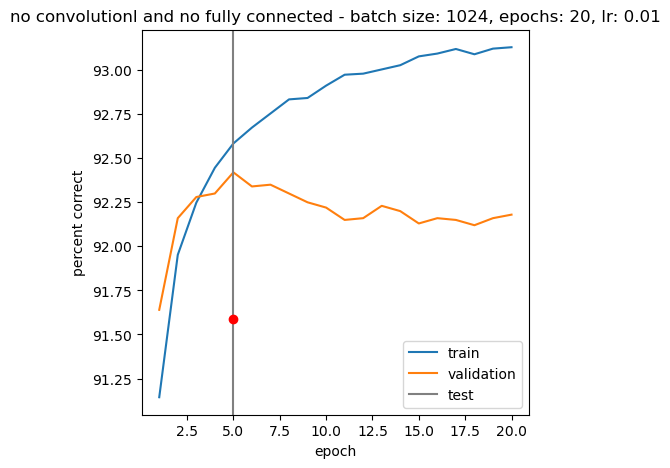

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 1024, number of epochs 20, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 88.8 Val 90.0
adam Epoch 4 % Correct: Train 90.8 Val 91.4
adam Epoch 6 % Correct: Train 91.6 Val 92.0
adam Epoch 8 % Correct: Train 92.0 Val 92.2
adam Epoch 10 % Correct: Train 92.3 Val 92.3
adam Epoch 12 % Correct: Train 92.5 Val 92.5
adam Epoch 14 % Correct: Train 92.6 Val 92.6
adam Epoch 16 % Correct: Train 92.8 Val 92.6
adam Epoch 18 % Correct: Train 92.9 Val 92.7
adam Epoch 20 % Correct: Train 93.0 Val 92.8
no convolutionl and no fully connected - batch size: 1024, epochs: 20, lr: 0.001: % correct: train 93.0 val 92.8 test 92.3


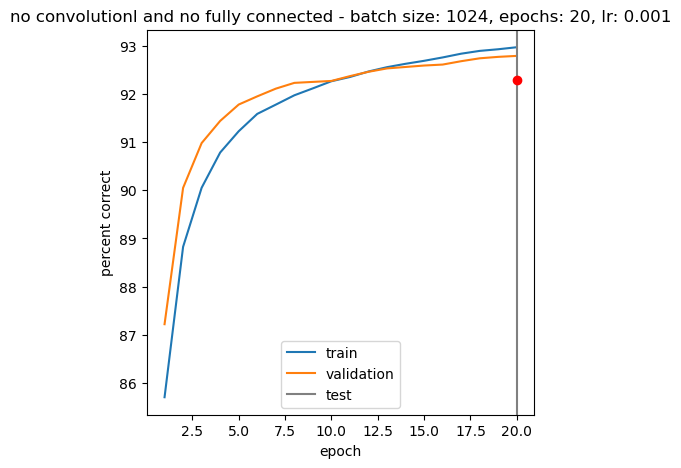

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 1024, number of epochs 20, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 2 % Correct: Train 66.5 Val 68.4
adam Epoch 4 % Correct: Train 77.4 Val 79.5
adam Epoch 6 % Correct: Train 81.9 Val 83.7
adam Epoch 8 % Correct: Train 84.4 Val 85.9
adam Epoch 10 % Correct: Train 85.9 Val 87.4
adam Epoch 12 % Correct: Train 86.9 Val 88.2
adam Epoch 14 % Correct: Train 87.6 Val 89.0
adam Epoch 16 % Correct: Train 88.3 Val 89.4
adam Epoch 18 % Correct: Train 88.7 Val 89.9
adam Epoch 20 % Correct: Train 89.1 Val 90.1
no convolutionl and no fully connected - batch size: 1024, epochs: 20, lr: 0.0001: % correct: train 89.1 val 90.1 test 89.2


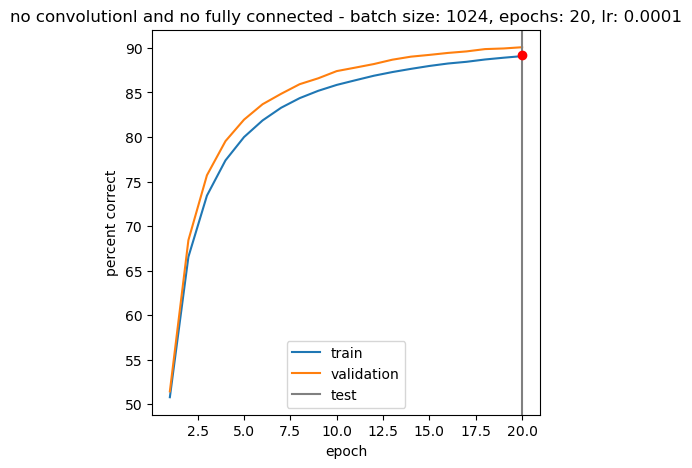

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 1024, number of epochs 30, learning rate 0.01
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 92.2 Val 92.4
adam Epoch 6 % Correct: Train 92.7 Val 92.4
adam Epoch 9 % Correct: Train 92.9 Val 92.2
adam Epoch 12 % Correct: Train 93.0 Val 92.3
adam Epoch 15 % Correct: Train 93.1 Val 92.2
adam Epoch 18 % Correct: Train 93.1 Val 92.2
adam Epoch 21 % Correct: Train 93.2 Val 92.1
adam Epoch 24 % Correct: Train 93.2 Val 92.0
adam Epoch 27 % Correct: Train 93.2 Val 92.0
adam Epoch 30 % Correct: Train 93.2 Val 92.0
no convolutionl and no fully connected - batch size: 1024, epochs: 30, lr: 0.01: % correct: train 92.8 val 92.4 test 91.6


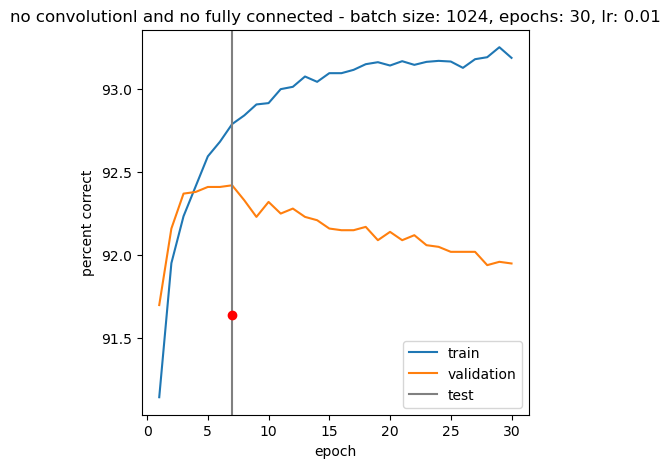

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 1024, number of epochs 30, learning rate 0.001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 90.1 Val 90.7
adam Epoch 6 % Correct: Train 91.5 Val 91.8
adam Epoch 9 % Correct: Train 92.1 Val 92.2
adam Epoch 12 % Correct: Train 92.4 Val 92.4
adam Epoch 15 % Correct: Train 92.7 Val 92.5
adam Epoch 18 % Correct: Train 92.9 Val 92.7
adam Epoch 21 % Correct: Train 93.0 Val 92.7
adam Epoch 24 % Correct: Train 93.1 Val 92.8
adam Epoch 27 % Correct: Train 93.3 Val 92.8
adam Epoch 30 % Correct: Train 93.4 Val 92.8
no convolutionl and no fully connected - batch size: 1024, epochs: 30, lr: 0.001: % correct: train 93.3 val 92.9 test 92.4


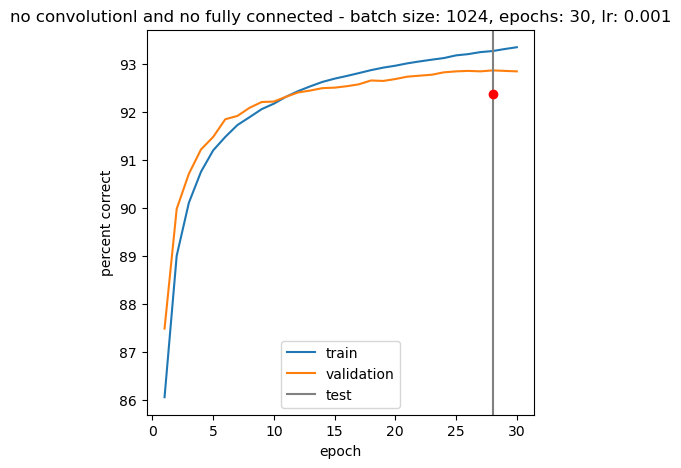

Percent Correct (Actual class in rows, Predicted class in columns)


Testing no convolutionl and no fully connected with batch size 1024, number of epochs 30, learning rate 0.0001
ConvNet2D: Using device cuda
adam Epoch 3 % Correct: Train 75.4 Val 78.2
adam Epoch 6 % Correct: Train 82.7 Val 84.9
adam Epoch 9 % Correct: Train 85.5 Val 87.3
adam Epoch 12 % Correct: Train 87.0 Val 88.6
adam Epoch 15 % Correct: Train 88.0 Val 89.5
adam Epoch 18 % Correct: Train 88.7 Val 90.0
adam Epoch 21 % Correct: Train 89.2 Val 90.4
adam Epoch 24 % Correct: Train 89.6 Val 90.8
adam Epoch 27 % Correct: Train 90.0 Val 91.1
adam Epoch 30 % Correct: Train 90.3 Val 91.2
no convolutionl and no fully connected - batch size: 1024, epochs: 30, lr: 0.0001: % correct: train 90.3 val 91.2 test 90.4


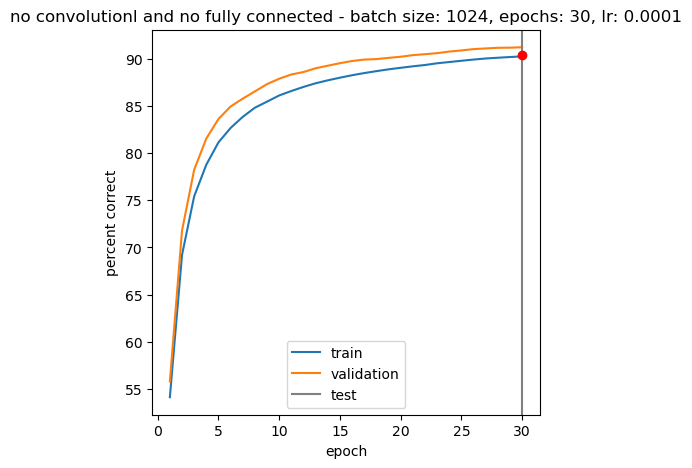

Percent Correct (Actual class in rows, Predicted class in columns)


                                           description  train accuracy  \
0     baseline - batch size: 256, epochs: 10, lr: 0.01          96.232   
1    baseline - batch size: 256, epochs: 10, lr: 0.001          99.060   
2    baseline - batch size: 256, epochs: 10, lr: 0....          92.664   
3     baseline - batch size: 256, epochs: 20, lr: 0.01          96.324   
4    baseline - batch size: 256, epochs: 20, lr: 0.001          99.642   
..                                                 ...             ...   
103  no convolutionl and no fully connected - batch...          92.970   
104  no convolutionl and no fully connected - batch...          89.080   
105  no convolutionl and no fully connected - batch...          92.788   
106  no convolutionl and no fully connected - batch...          93.274   
107  no convolutionl and no fully connected - batch...          90.254   

     val accuracy  test accuracy  
0           96.25          95.97  
1           98.22          98.04  
2     

In [11]:
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

batch_sizes = [256, 512, 1024]
n_epochs_list = [10, 20, 30]
learning_rates = [0.01, 0.001, 0.0001]

architectures = [
    {"conv_specs": [(40, 4, 1), (20, 3, 2), (20, 3, 2)], "fc_specs": [20], "description": "baseline"},
    {"conv_specs": [(40, 4, 1), (20, 3, 2), (20, 3, 2)], "fc_specs": [], "description": "no fully conected"},
    {"conv_specs": [], "fc_specs": [100, 100], "description": "no convolutional"},
    {"conv_specs": [], "fc_specs": [], "description": "no convolutionl and no fully connected"}
]

results = []

def ErfanFunc(nnet, description):

    with gzip.open('mnist.pkl.gz', 'rb') as f:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

    Xtrain = train_set[0]
    Ttrain = train_set[1]
    Xval = valid_set[0]
    Tval = valid_set[1]
    Xtest = test_set[0]
    Ttest = test_set[1]

    pc_train = nnet.percent_correct(nnet.use(Xtrain), Ttrain)
    pc_val = nnet.percent_correct(nnet.use(Xval), Tval)
    pc_test = nnet.percent_correct(nnet.use(Xtest), Ttest)

    print(f'{description}: % correct: train {pc_train:.1f} val {pc_val:.1f} test {pc_test:.1f}')
    plt.figure(figsize=(5, 5))
    plt.plot(1 + np.arange(len(nnet.pc_trace)), nnet.pc_trace)
    plt.axvline(nnet.best_epoch, color='gray')
    plt.plot(nnet.best_epoch, pc_test, 'ro')
    plt.legend(('train', 'validation', 'test'))
    plt.xlabel('epoch')
    plt.ylabel('percent correct')
    plt.title(description)
    plt.show()

    results.append({
        "description": description,
        "train accuracy": pc_train,
        "val accuracy": pc_val,
        "test accuracy": pc_test
    })
    
    display(confusion_matrix(nnet.use(Xtest), Ttest, range(10), 'Blues'))

    
for architecture in architectures:
    for batch_size in batch_sizes:
        for n_epochs in n_epochs_list:
            for learning_rate in learning_rates:
                print(f"Testing {architecture['description']} with batch size {batch_size}, number of epochs {n_epochs}, learning rate {learning_rate}")
                conv_specs = architecture["conv_specs"]
                fc_specs = architecture["fc_specs"]

                nnet = ConvNet(input_shape=(1, 28, 28), conv_specs=conv_specs, fc_specs=fc_specs, 
                               n_outputs=10, activation_function='tanh', device=device)
                nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size, 'adam', learning_rate)
                ErfanFunc(nnet, f"{architecture['description']} - batch size: {batch_size}, epochs: {n_epochs}, lr: {learning_rate}")


results = pd.DataFrame(results)
print(results)


# EMG as one-dimensional data

To demonstrate that your `ConvNet` works for one-dimensional data, apply it to the following data.

[EMG (electromyography)](https://en.wikipedia.org/wiki/Electromyography) is a way to record electrical activity from muscles.  The Myo armband, pictured below, is a simple device that includes eight sensors and connects to a computer via bluetooth. Unfortunately, I don't think it is available any more.

<img src="https://www.cs.colostate.edu/~anderson/cs545/notebooks/figures/myo.jpg" width="700"> 

We purchased one some time ago for the CSU Computer Science department.  You might guess that the eight channels of streaming data could be used for gesture recognition experiments.

This is the subject of Requirement 3.  You will apply your `ConvNet` class to this data, which is one-dimensional.  Rather than the two dimensions of height and width in images, this data has only one dimension, time.  However, rather than the single channel of pixel intensity we had for the MNIST images, this data has eight channels. 

Here is code to obtain and read some sample data from nine different gestures.  First, [download emg.npz](https://www.cs.colostate.edu/~anderson/cs545/notebooks/emg.npz).

In [12]:
gestures = ['relax','fist','open-close','up','down','flick-right',
            'flick-left','circle-left','circle-right']

dict = np.load('emg.npz')
Xtrain = dict['Xtrain']
Ttrain = dict['Ttrain']
Xval = dict['Xval']
Tval = dict['Tval']
Xtest = dict['Xtest']
Ttest = dict['Ttest']

Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

FileNotFoundError: [Errno 2] No such file or directory: 'emg.npz'

Each of the 72 samples in the `X` arrays contains 20 samples of EMG from each of the 8 sensors, or channels.  Here are some examples.

In [ ]:
plt.figure(figsize=(10, 8))
ploti = 0
for gesturei in range(len(gestures)):
    ploti += 1
    plt.subplot(3, 3, ploti)
    sample_indices = np.where(Ttrain == gesturei)[0]
    plt.plot(Xtrain[sample_indices[0], :, :].T)
    plt.title(gestures[gesturei])
    if gesturei == 0:
        plt.legend([f'Channel {i}' for i in range(1, 9)])
plt.tight_layout()

# Requirement 2

As you did for the MNIST data, run some experiments with this EMG data. As before, answer questions about how helpful convolutional and fully-connected layers are, and what parameter values produce your best results on test data.

Include plots of `nnet.pc_trace` and show confusion matrices.

# Check In

Check in your jupyter notebook in Canvas. 

There is no grading script provided for this assignment.  All grading will be done by running and reading your notebook. 
50% of your grade will be based on your MNIST experiments and 50% on your EMG experiments.

# Extra Credit

You will earn one extra credit point for each of the following four items that you complete satisfactorily.


1. For the MNIST and EMG data, run experiments using the `relu` rather than `tanh` activation function.  Are the results similar or is one activation function better than the other?
1. Run your `ConvNet` on a different image data set with three channels, for red, green and blue pixel intensities.  An often-used example dataset is [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html). You may download such data sets, then reduce the number of samples to be able to run some experiments with various parameter values.
2. Run your `ConvNet` on the accelerometer data we used in previous lectures.  This will have three channels, for accelerations in x, y and z.
3. Using either the MNIST or EMG data, or data from the above two extra credit steps, train an ensemble of at least 10 `ConvNet`s on the data and compare the results you get for just one `ConvNet`.


Extra credit points will affect your semester grade in the following way.  Each extra credit point you have earned during the semester will add about half a point to your semester average grade, for a max of 3 semester average grade points.  So, if you have 6 extra credit points for the semester and your semester average is 77, your semester grade will be B-.

<font color=red>The maximum number of extra credit points that will count for the semester is 6.</font> 